# Кластеризейшн анализейшн
Домашнее задание: EDA → Preprocessing → Кластеризация → Интерпретация.

Источник данных: UCI Statlog German Credit Data.


In [54]:
# === Установка и импорт зависимостей ===
import sys, subprocess

def pip_install(pkg):
    try:
        __import__(pkg.split("==")[0].replace("-", "_"))
    except ImportError:
        print(f"Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

pip_install("umap-learn")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from urllib.request import urlretrieve, URLError
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.manifold import TSNE

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)


Installing umap-learn ...


## Часть 1. EDA и Preprocessing
### 1) Загрузка данных (автоматически с UCI, без Kaggle)
Если локального CSV нет — скачаем `german.data` с UCI, проставим имена столбцов и сохраним как `german_credit_data.csv`.


In [55]:
# === Загрузка данных из UCI  ===
csv_path = "german_credit_data.csv"

if not os.path.exists(csv_path):
    print("CSV не найден, скачиваю исходные данные из UCI...")
    base_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/"
    raw_file = "german.data"
    url = base_url + raw_file
    try:
        urlretrieve(url, raw_file)
        print("Скачано:", url)
    except URLError as e:
        raise SystemExit(f"Ошибка при скачивании UCI: {e}")

    # Имена столбцов из описания набора данных
    columns = [
        "status", "duration", "credit_history", "purpose", "credit_amount",
        "savings", "employment", "installment_rate", "personal_status_sex",
        "other_debtors", "present_residence", "property", "age",
        "other_installment_plans", "housing", "number_credits", "job",
        "people_liable", "telephone", "foreign_worker", "target"
    ]

    df = pd.read_csv(raw_file, sep="\s+", header=None, names=columns)

    df["target"] = df["target"].map({1: "good", 2: "bad"}).astype("category")

    df.to_csv(csv_path, index=False)
    print("Сохранено как:", csv_path)
else:
    df = pd.read_csv(csv_path)

print("Форма:", df.shape)
df.head()


Форма: (1000, 21)


status  duration credit_history purpose  credit_amount savings employment  \
0    A11         6            A34     A43           1169     A65        A75   
1    A12        48            A32     A43           5951     A61        A73   
2    A14        12            A34     A46           2096     A61        A74   
3    A11        42            A32     A42           7882     A61        A74   
4    A11        24            A33     A40           4870     A61        A73   

   installment_rate personal_status_sex other_debtors  present_residence  \
0                 4                 A93          A101                  4   
1                 2                 A92          A101                  2   
2                 2                 A93          A101                  3   
3                 2                 A93          A103                  4   
4                 3                 A93          A101                  4   

  property  age other_installment_plans housing  number_credits   job  \
0     A121   67                    A143    A152               2  A173   
1     A121   22                    A143    A152               1  A173   
2     A121   49                    A143    A152               1  A172   
3     A122   45                    A143    A153               1  A173   
4     A124   53                    A143    A153               2  A173   

   people_liable telephone foreign_worker target  
0              1      A192           A201   good  
1              1      A191           A201    bad  
2              2      A191           A201   good  
3              2      A191           A201   good  
4              2      A191           A201    bad

### 2) Полный стол еды

In [56]:
# Общая информация
display(df.info())
display(df.describe(include="all"))
display(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   status                   1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   credit_amount            1000 non-null   int64 
 5   savings                  1000 non-null   object
 6   employment               1000 non-null   object
 7   installment_rate         1000 non-null   int64 
 8   personal_status_sex      1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  present_residence        1000 non-null   int64 
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

None

status     duration credit_history purpose  credit_amount savings  \
count    1000  1000.000000           1000    1000    1000.000000    1000   
unique      4          NaN              5      10            NaN       5   
top       A14          NaN            A32     A43            NaN     A61   
freq      394          NaN            530     280            NaN     603   
mean      NaN    20.903000            NaN     NaN    3271.258000     NaN   
std       NaN    12.058814            NaN     NaN    2822.736876     NaN   
min       NaN     4.000000            NaN     NaN     250.000000     NaN   
25%       NaN    12.000000            NaN     NaN    1365.500000     NaN   
50%       NaN    18.000000            NaN     NaN    2319.500000     NaN   
75%       NaN    24.000000            NaN     NaN    3972.250000     NaN   
max       NaN    72.000000            NaN     NaN   18424.000000     NaN   

       employment  installment_rate personal_status_sex other_debtors  \
count        1000       1000.000000                1000          1000   
unique          5               NaN                   4             3   
top           A73               NaN                 A93          A101   
freq          339               NaN                 548           907   
mean          NaN          2.973000                 NaN           NaN   
std           NaN          1.118715                 NaN           NaN   
min           NaN          1.000000                 NaN           NaN   
25%           NaN          2.000000                 NaN           NaN   
50%           NaN          3.000000                 NaN           NaN   
75%           NaN          4.000000                 NaN           NaN   
max           NaN          4.000000                 NaN           NaN   

        present_residence property          age other_installment_plans  \
count         1000.000000     1000  1000.000000                    1000   
unique                NaN        4          NaN                       3   
top                   NaN     A123          NaN                    A143   
freq                  NaN      332          NaN                     814   
mean             2.845000      NaN    35.546000                     NaN   
std              1.103718      NaN    11.375469                     NaN   
min              1.000000      NaN    19.000000                     NaN   
25%              2.000000      NaN    27.000000                     NaN   
50%              3.000000      NaN    33.000000                     NaN   
75%              4.000000      NaN    42.000000                     NaN   
max              4.000000      NaN    75.000000                     NaN   

       housing  number_credits   job  people_liable telephone foreign_worker  \
count     1000     1000.000000  1000    1000.000000      1000           1000   
unique       3             NaN     4            NaN         2              2   
top       A152             NaN  A173            NaN      A191           A201   
freq       713             NaN   630            NaN       596            963   
mean       NaN        1.407000   NaN       1.155000       NaN            NaN   
std        NaN        0.577654   NaN       0.362086       NaN            NaN   
min        NaN        1.000000   NaN       1.000000       NaN            NaN   
25%        NaN        1.000000   NaN       1.000000       NaN            NaN   
50%        NaN        1.000000   NaN       1.000000       NaN            NaN   
75%        NaN        2.000000   NaN       1.000000       NaN            NaN   
max        NaN        4.000000   NaN       2.000000       NaN            NaN   

       target  
count    1000  
unique      2  
top      good  
freq      700  
mean      NaN  
std       NaN  
min       NaN  
25%       NaN  
50%       NaN  
75%       NaN  
max       NaN

status                     0
duration                   0
credit_history             0
purpose                    0
credit_amount              0
savings                    0
employment                 0
installment_rate           0
personal_status_sex        0
other_debtors              0
present_residence          0
property                   0
age                        0
other_installment_plans    0
housing                    0
number_credits             0
job                        0
people_liable              0
telephone                  0
foreign_worker             0
target                     0
dtype: int64

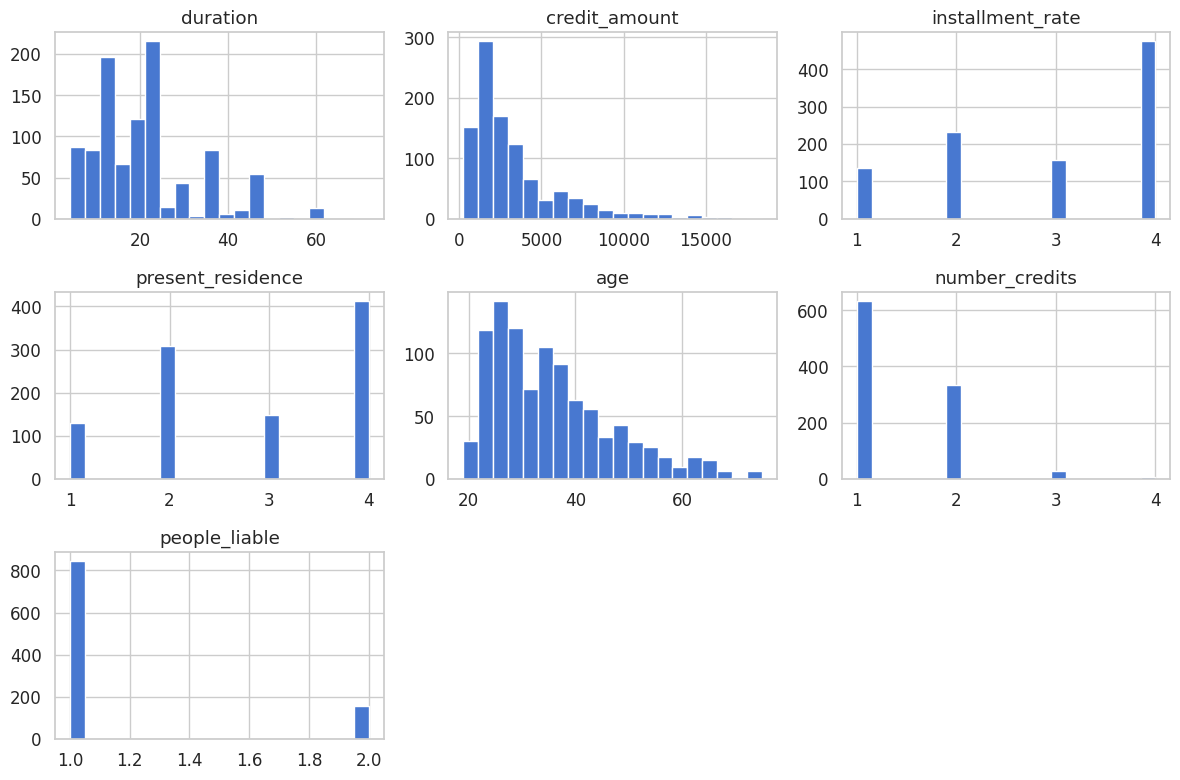

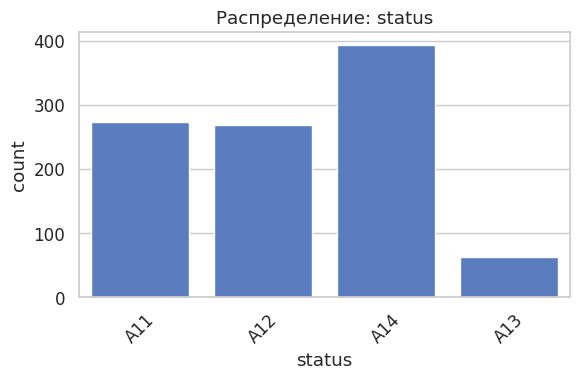

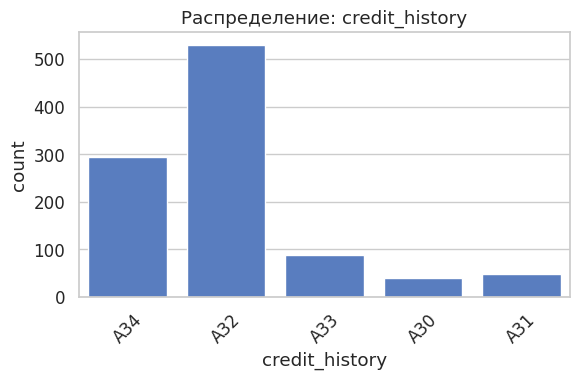

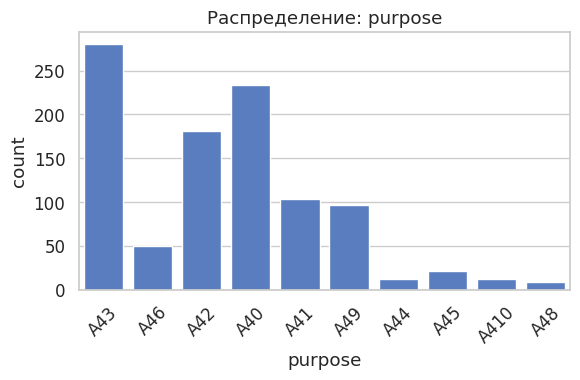

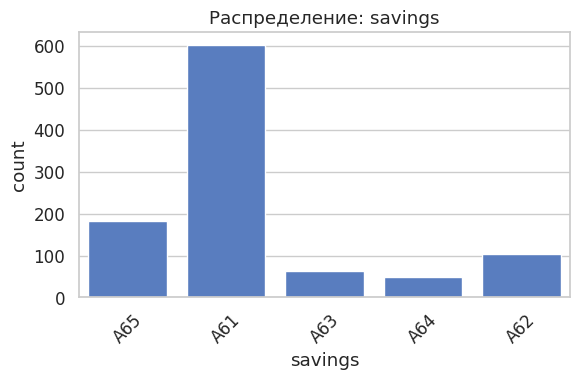

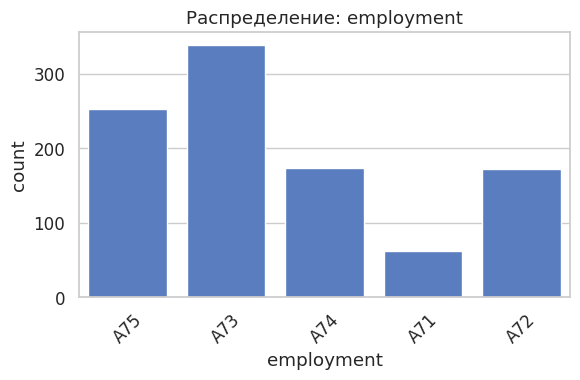

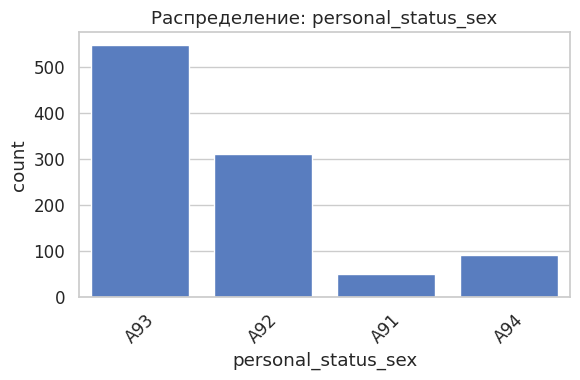

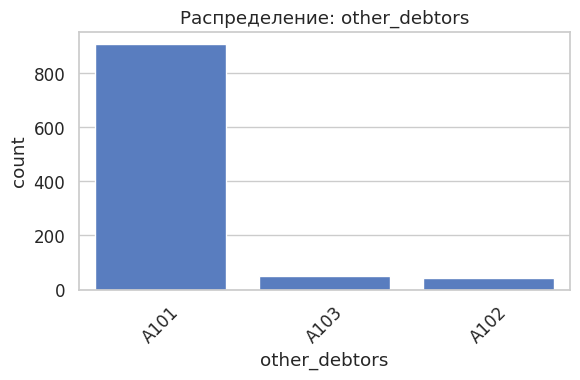

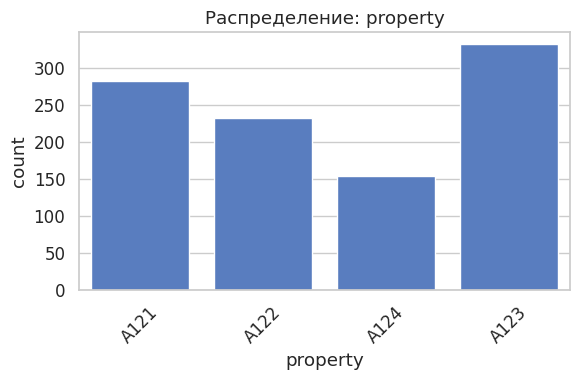

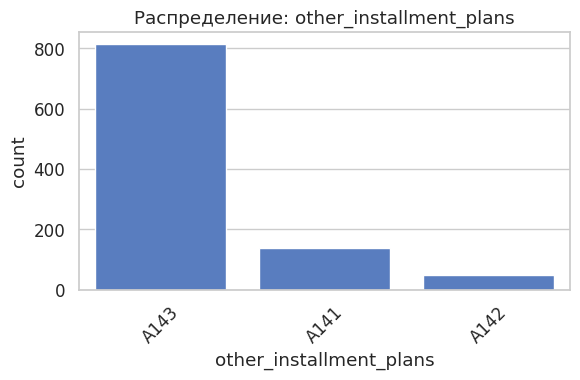

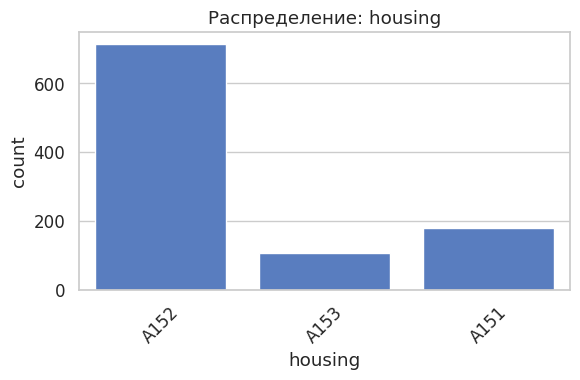

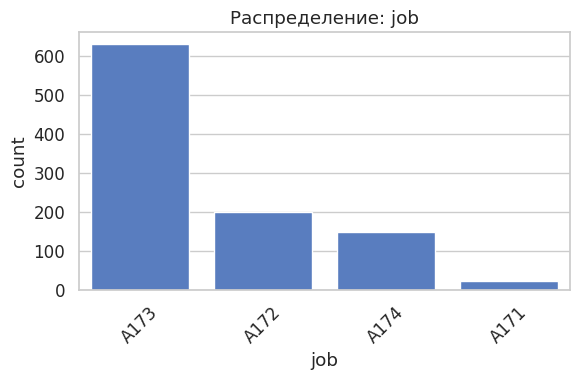

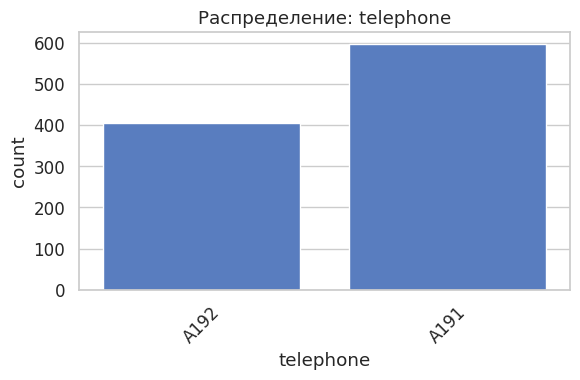

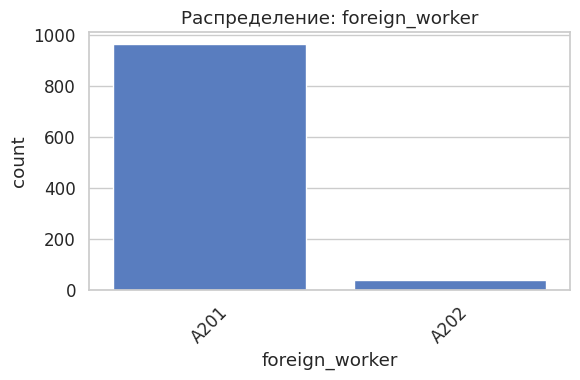

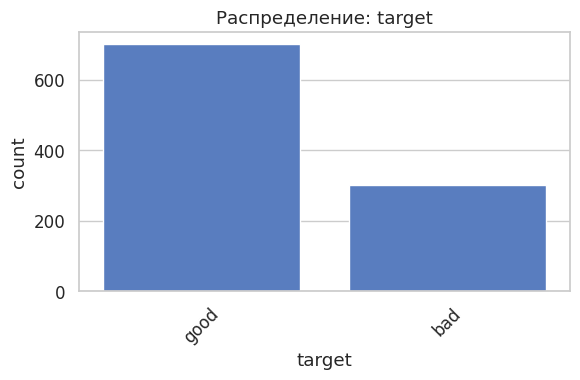

In [57]:
# Гистограммы числовых признаков
num_cols = df.select_dtypes(include=np.number).columns
if len(num_cols) > 0:
    df[num_cols].hist(figsize=(12, 8), bins=20)
    plt.tight_layout()
    plt.show()

# Распределение категориальных признаков
cat_cols = df.select_dtypes(exclude=np.number).columns
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col)
    plt.title(f"Распределение: {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### 3) Долой категории, даешь нормализацию
Целевую переменную исключаем.

In [58]:
# Отделим целевую переменную (не используется в кластеризации)
target_candidates = [c for c in ["target", "Risk", "label", "Target"] if c in df.columns]
y = df[target_candidates[0]] if len(target_candidates) else None
X = df.drop(columns=target_candidates[0]) if len(target_candidates) else df.copy()

# One-Hot (get_dummies) для всех категориальных (их не очень много)
X_encoded = pd.get_dummies(X, drop_first=True)

# Масштабирование (важно для кластеризации на основе расстояний)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
X_scaled = pd.DataFrame(X_scaled, columns=X_encoded.columns)

print("Размерность после кодирования и масштабирования:", X_scaled.shape)
X_scaled.head()


Размерность после кодирования и масштабирования: (1000, 48)


duration  credit_amount  installment_rate  present_residence       age  \
0 -1.236478      -0.745131          0.918477           1.046987  2.766456   
1  2.248194       0.949817         -0.870183          -0.765977 -1.191404   
2 -0.738668      -0.416562         -0.870183           0.140505  1.183312   
3  1.750384       1.634247         -0.870183           1.046987  0.831502   
4  0.256953       0.566664          0.024147           1.046987  1.535122   

   number_credits  people_liable  status_A12  status_A13  status_A14  \
0        1.027079      -0.428290   -0.606621   -0.259299   -0.806328   
1       -0.704926      -0.428290    1.648476   -0.259299   -0.806328   
2       -0.704926       2.334869   -0.606621   -0.259299    1.240190   
3       -0.704926       2.334869   -0.606621   -0.259299   -0.806328   
4        1.027079       2.334869   -0.606621   -0.259299   -0.806328   

   credit_history_A31  credit_history_A32  credit_history_A33  \
0           -0.226991           -1.061913            -0.31063   
1           -0.226991            0.941697            -0.31063   
2           -0.226991           -1.061913            -0.31063   
3           -0.226991            0.941697            -0.31063   
4           -0.226991           -1.061913             3.21926   

   credit_history_A34  purpose_A41  purpose_A410  purpose_A42  purpose_A43  \
0            1.553374    -0.338862     -0.110208    -0.470108     1.603567   
1           -0.643760    -0.338862     -0.110208    -0.470108     1.603567   
2            1.553374    -0.338862     -0.110208    -0.470108    -0.623610   
3           -0.643760    -0.338862     -0.110208     2.127172    -0.623610   
4           -0.643760    -0.338862     -0.110208    -0.470108    -0.623610   

   purpose_A44  purpose_A45  purpose_A46  purpose_A48  purpose_A49  \
0    -0.110208    -0.149983    -0.229416    -0.095298    -0.327749   
1    -0.110208    -0.149983    -0.229416    -0.095298    -0.327749   
2    -0.110208    -0.149983     4.358899    -0.095298    -0.327749   
3    -0.110208    -0.149983    -0.229416    -0.095298    -0.327749   
4    -0.110208    -0.149983    -0.229416    -0.095298    -0.327749   

   savings_A62  savings_A63  savings_A64  savings_A65  employment_A72  \
0    -0.338862    -0.259299    -0.224544     2.112932       -0.455773   
1    -0.338862    -0.259299    -0.224544    -0.473276       -0.455773   
2    -0.338862    -0.259299    -0.224544    -0.473276       -0.455773   
3    -0.338862    -0.259299    -0.224544    -0.473276       -0.455773   
4    -0.338862    -0.259299    -0.224544    -0.473276       -0.455773   

   employment_A73  employment_A74  employment_A75  personal_status_sex_A92  \
0       -0.716142        -0.45897        1.718304                -0.670280   
1        1.396371        -0.45897       -0.581969                 1.491914   
2       -0.716142         2.17879       -0.581969                -0.670280   
3       -0.716142         2.17879       -0.581969                -0.670280   
4        1.396371        -0.45897       -0.581969                -0.670280   

   personal_status_sex_A93  personal_status_sex_A94  other_debtors_A102  \
0                 0.908195                -0.318311           -0.206768   
1                -1.101086                -0.318311           -0.206768   
2                 0.908195                -0.318311           -0.206768   
3                 0.908195                -0.318311           -0.206768   
4                 0.908195                -0.318311           -0.206768   

   other_debtors_A103  property_A122  property_A123  property_A124  \
0           -0.234206      -0.549621      -0.704987      -0.426653   
1           -0.234206      -0.549621      -0.704987      -0.426653   
2           -0.234206      -0.549621      -0.704987      -0.426653   
3            4.269750       1.819435      -0.704987      -0.426653   
4           -0.234206      -0.549621      -0.704987       2.343823   

   other_installment_plans_A142  other_install

> **Почему важно масштабирование при кластеризации?**  
Алгоритмы, использующие расстояния (например, K-Means, Ward linkage), чувствительны к масштабу признаков.  
Без нормализации признаки с большими численными диапазонами доминируют над остальными и искажают расстояния.

## Часть 2. Кластеризация (всех по лавкам)
Будем строить K-Means, иерархическую кластеризацию и DBSCAN. Подбор числа кластеров — по Elbow и Silhouette.


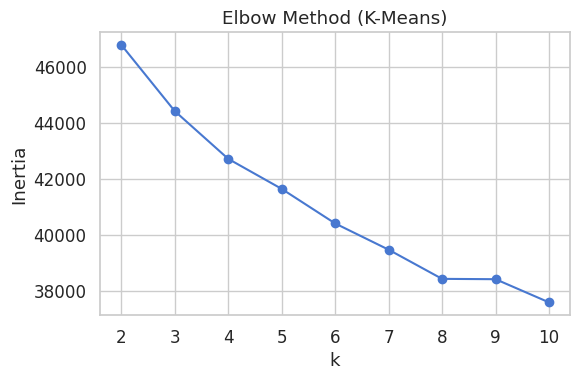

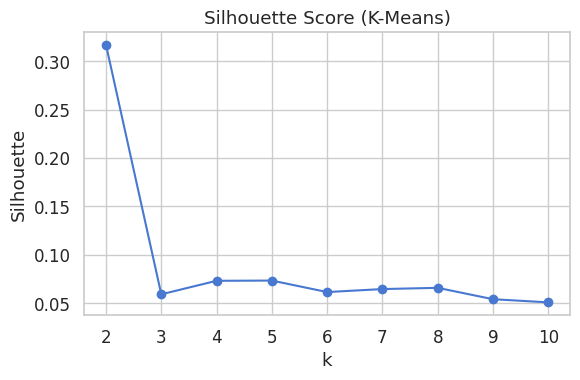

Лучшее k по силуэту: 2 (score=0.317)
 ... но мы возьмем лучшее по локтю - 7 ...


In [69]:
# === K-Means: Elbow + Silhouette ===
inertia = []
sil_scores = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Elbow
plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertia, marker='o')
plt.title("Elbow Method (K-Means)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

# Silhouette
plt.figure(figsize=(6,4))
plt.plot(list(K_range), sil_scores, marker='o')
plt.title("Silhouette Score (K-Means)")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

best_k = K_range[np.argmax(sil_scores)]
print(f"Лучшее k по силуэту: {best_k} (score={max(sil_scores):.3f})")

print(f" ... но мы возьмем лучшее по локтю - 7 ...")

kmeans = KMeans(n_clusters=7, n_init="auto", random_state=42)
labels_km = kmeans.fit_predict(X_scaled)


Сложно что-то по этой картинке сказать. Как будто локоть на 7-8 кластерах, а силуэт говорил - 2

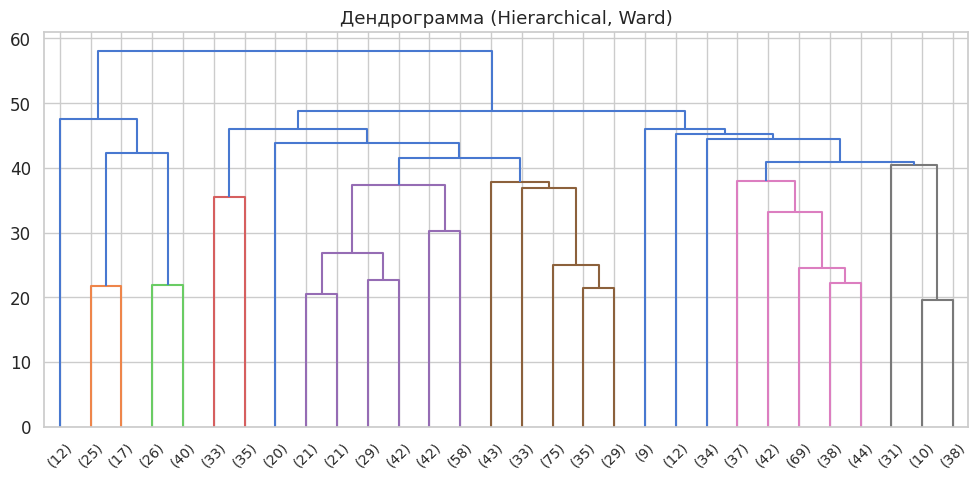

In [70]:
# === Иерархическая кластеризация (Ward) ===
linked = linkage(X_scaled, method="ward")
plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode="lastp", p=30, leaf_rotation=45., leaf_font_size=10.)
plt.title("Дендрограмма (Hierarchical, Ward)")
plt.tight_layout()
plt.show()


Для двух кластеров надо выбирать отсчение от 20 до 25 в иерархии. Для 7 - где то в районе 40-42

In [77]:
# === DBSCAN: простой перебор нескольких eps и min_samples ===
eps_values = np.linspace(7,9,20)
min_samples_values = range(2,5)
best_sil = -1
best_params = []
best_labels_db = []
for eps in eps_values:
  for min_samples_val in min_samples_values:
    db = DBSCAN(eps=eps, min_samples=min_samples_val)
    labels_db = db.fit_predict(X_scaled)
    n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
    if n_clusters > 1:
        sil = silhouette_score(X_scaled, labels_db)
        print(f"DBSCAN eps={eps}, min_samples={min_samples_val}: clusters={n_clusters}, silhouette={sil:.3f}")
        if sil > best_sil:
          best_sil = sil
          best_params = [eps, min_samples_val]
          best_labels_db = labels_db
    else:
        print(f"DBSCAN eps={eps}, min_samples={min_samples_val}: clusters={n_clusters} (силуэт не считается)")


DBSCAN eps=7.0, min_samples=2: clusters=8, silhouette=0.103
DBSCAN eps=7.0, min_samples=3: clusters=6, silhouette=0.137
DBSCAN eps=7.0, min_samples=4: clusters=5, silhouette=0.147
DBSCAN eps=7.105263157894737, min_samples=2: clusters=6, silhouette=0.137
DBSCAN eps=7.105263157894737, min_samples=3: clusters=6, silhouette=0.137
DBSCAN eps=7.105263157894737, min_samples=4: clusters=5, silhouette=0.153
DBSCAN eps=7.2105263157894735, min_samples=2: clusters=7, silhouette=0.147
DBSCAN eps=7.2105263157894735, min_samples=3: clusters=5, silhouette=0.161
DBSCAN eps=7.2105263157894735, min_samples=4: clusters=5, silhouette=0.161
DBSCAN eps=7.315789473684211, min_samples=2: clusters=6, silhouette=0.193
DBSCAN eps=7.315789473684211, min_samples=3: clusters=4, silhouette=0.224
DBSCAN eps=7.315789473684211, min_samples=4: clusters=4, silhouette=0.224
DBSCAN eps=7.421052631578947, min_samples=2: clusters=6, silhouette=0.197
DBSCAN eps=7.421052631578947, min_samples=3: clusters=4, silhouette=0.233
DBS

Ничего не ясно. Пробовал варьировать параметры - силуэт не сильно меняется

## Снижение размерности и визуализация кластеров
PCA, UMAP и t-SNE до 2D для наглядности (окрашивание по меткам K-Means).

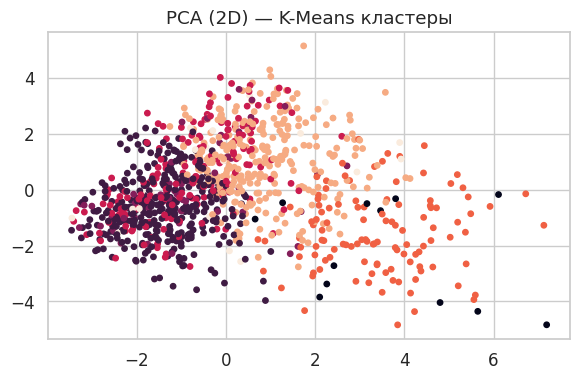

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


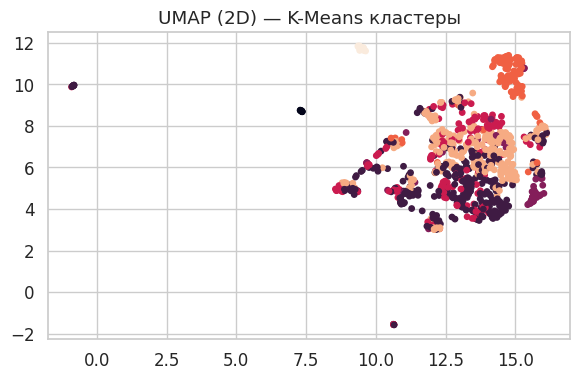

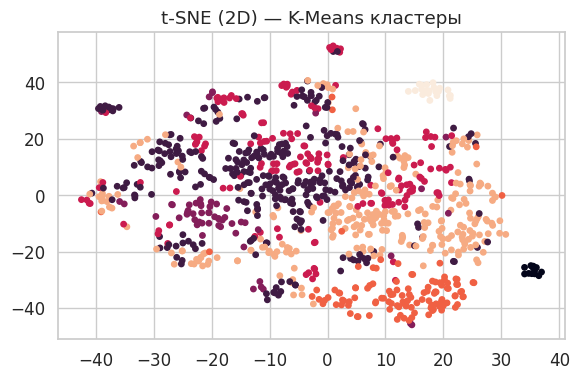

In [72]:
# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_km, s=15)
plt.title("PCA (2D) — K-Means кластеры")
plt.tight_layout()
plt.show()

# UMAP
um = umap.UMAP(random_state=42)
X_umap = um.fit_transform(X_scaled)

plt.figure(figsize=(6,4))
plt.scatter(X_umap[:,0], X_umap[:,1], c=labels_km, s=15)
plt.title("UMAP (2D) — K-Means кластеры")
plt.tight_layout()
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto")
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(6,4))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels_km, s=15)
plt.title("t-SNE (2D) — K-Means кластеры")
plt.tight_layout()
plt.show()


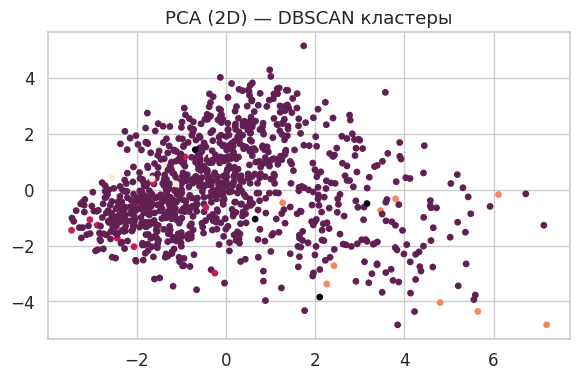

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


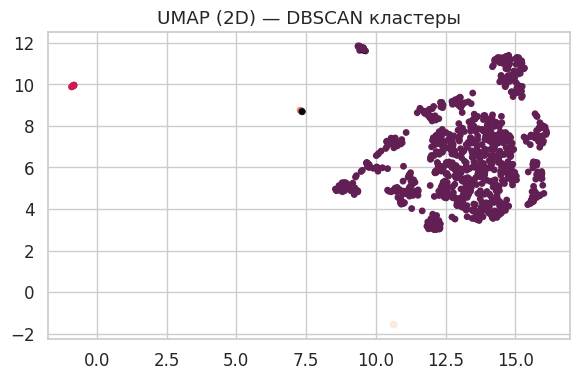

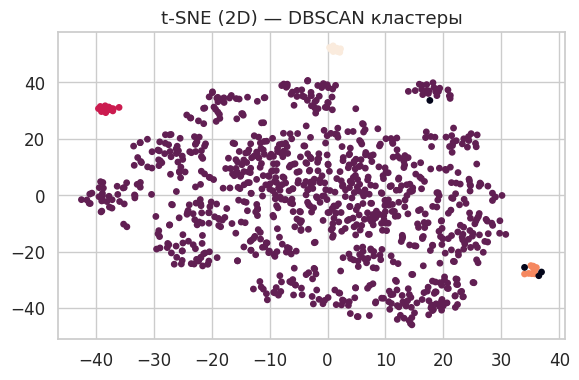

In [78]:
# то же самое для DB:
# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=best_labels_db, s=15)
plt.title("PCA (2D) — DBSCAN кластеры")
plt.tight_layout()
plt.show()

# UMAP
um = umap.UMAP(random_state=42)
X_umap = um.fit_transform(X_scaled)

plt.figure(figsize=(6,4))
plt.scatter(X_umap[:,0], X_umap[:,1], c=best_labels_db, s=15)
plt.title("UMAP (2D) — DBSCAN кластеры")
plt.tight_layout()
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto")
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(6,4))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=best_labels_db, s=15)
plt.title("t-SNE (2D) — DBSCAN кластеры")
plt.tight_layout()
plt.show()


Сумма объяснённой дисперсии (15 компонент): 0.553


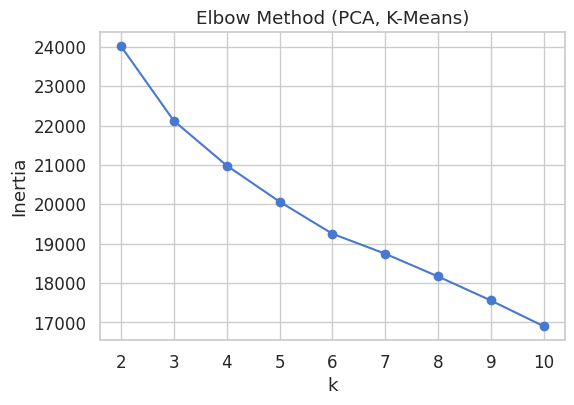

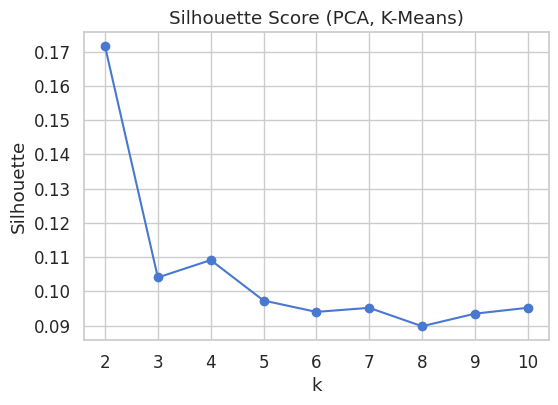

Лучшее k по силуэту (PCA): 2, score=0.172


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


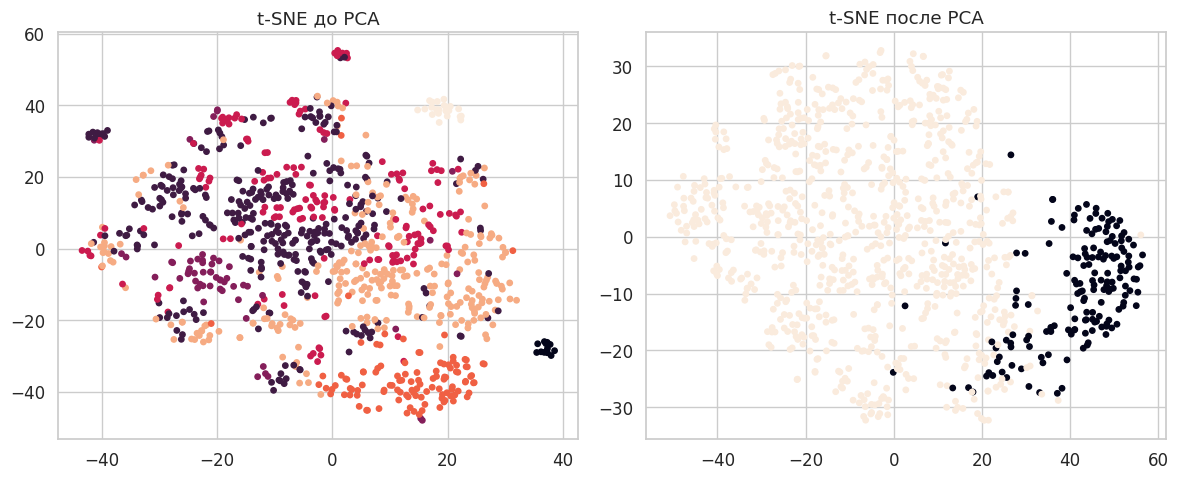

In [86]:
# что то все выглядит криво - возможно потому что нужно пожать по главным компонентам
# попробуем это сделать

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# --- PCA до 15 компонент ---
pca = PCA(n_components=15, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Сумма объяснённой дисперсии (15 компонент):", round(pca.explained_variance_ratio_.sum(), 3))

# --- Elbow и Silhouette на PCA-пространстве ---
inertia_pca = []
sil_scores_pca = []
K_range = range(2, 11)
for k in K_range:
    km_pca = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels_pca = km_pca.fit_predict(X_pca)
    inertia_pca.append(km_pca.inertia_)
    sil_scores_pca.append(silhouette_score(X_pca, labels_pca))

# Elbow plot
plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertia_pca, marker='o')
plt.title("Elbow Method (PCA, K-Means)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

# Silhouette plot
plt.figure(figsize=(6,4))
plt.plot(list(K_range), sil_scores_pca, marker='o')
plt.title("Silhouette Score (PCA, K-Means)")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

# --- Лучшее k по силуэту ---
best_k_pca = K_range[np.argmax(sil_scores_pca)]
print(f"Лучшее k по силуэту (PCA): {best_k_pca}, score={max(sil_scores_pca):.3f}")

# --- Модель KMeans на PCA-пространстве ---
kmeans_pca = KMeans(n_clusters=best_k_pca, n_init="auto", random_state=42)
labels_km_pca = kmeans_pca.fit_predict(X_pca)

# --- Сравнение t-SNE до и после PCA ---
fig, axs = plt.subplots(1, 2, figsize=(12,5))

tsne_orig = TSNE(n_components=2, perplexity=30, n_iter=1500, random_state=42)
X_tsne_orig = tsne_orig.fit_transform(X_scaled)
axs[0].scatter(X_tsne_orig[:,0], X_tsne_orig[:,1], c=labels_km, s=15)
axs[0].set_title("t-SNE до PCA")

tsne_pca = TSNE(n_components=2, perplexity=30, n_iter=1500, random_state=42)
X_tsne_pca = tsne_pca.fit_transform(X_pca)
axs[1].scatter(X_tsne_pca[:,0], X_tsne_pca[:,1], c=labels_km_pca, s=15)
axs[1].set_title("t-SNE после PCA")

plt.tight_layout()
plt.show()


## Часть 3. Интерпретация кластеров
- Расчёт средних значений признаков по кластерам  
- Boxplot'ы для каждого признака, сгруппированные по кластерам

In [82]:
# Добавим метки кластеров в таблицу признаков (стандартизированных)
X_vis = X_scaled.copy()
X_vis["Cluster"] = labels_km

# Средние (в стандартизированном пространстве)
cluster_means = X_vis.groupby("Cluster").mean(numeric_only=True)
cluster_means


duration  credit_amount  installment_rate  present_residence  \
Cluster                                                                 
0        0.948356       1.750268         -0.273963           0.367125   
1       -0.151469      -0.235001         -0.178142          -0.258779   
2       -0.328192      -0.382032         -0.211203          -0.368397   
3       -0.409688      -0.365075         -0.069446           0.024559   
4        0.638755       0.733126          0.142863           0.605779   
5        0.207691       0.221938          0.225992           0.093292   
6       -0.150346      -0.192522          0.268055           0.181708   

              age  number_credits  people_liable  status_A12  status_A13  \
Cluster                                                                    
0        0.384411        0.161076       0.032237    0.708852   -0.259299   
1       -0.478884       -0.323473      -0.296711    0.071250   -0.259299   
2        0.005984       -0.218749      -0.040478   -0.606621    3.856555   
3        0.039419        0.020099       0.278565    0.062041   -0.259299   
4        0.617459       -0.076499       0.256387    0.012034   -0.040758   
5        0.255536        0.395619       0.070614   -0.058507   -0.259299   
6        0.263809        0.475986       0.199701    0.315919   -0.259299   

         status_A14  credit_history_A31  credit_history_A32  \
Cluster                                                       
0         -0.635785            0.545086           -0.394043   
1         -0.008430           -0.116694            0.428868   
2         -0.806328            0.016823            0.168374   
3         -0.021036            0.042339           -0.001864   
4         -0.244894            0.223957           -0.086705   
5          0.309308            0.014283           -0.477527   
6         -0.062140           -0.226991           -0.060108   

         credit_history_A33  credit_history_A34  purpose_A41  purpose_A410  \
Cluster                                                                      
0                  0.277685           -0.094477    -0.338862      9.073772   
1                 -0.111023           -0.329884    -0.054910     -0.110208   
2                 -0.124847           -0.104113    -0.281144     -0.110208   
3                 -0.043836            0.033264    -0.243224     -0.110208   
4                  0.032987           -0.079894     0.476339     -0.110208   
5                  0.142863            0.424291     0.118072     -0.110208   
6                  0.170718           -0.044542    -0.338862     -0.110208   

         purpose_A42  purpose_A43  purpose_A44  purpose_A45  purpose_A46  \
Cluster                                                                    
0          -0.470108    -0.623610    -0.110208    -0.149983    -0.229416   
1           0.148292     0.098897     0.163125    -0.149983    -0.065547   
2          -0.014445     0.275076     0.050915    -0.149983     0.092571   
3          -0.017094     0.036774    -0.056813    -0.149983    -0.069358   
4          -0.148321    -0.347676    -0.110208    -0.149983     0.542071   
5          -0.046246     0.018250    -0.110208    -0.149983    -0.086031   
6          -0.470108    -0.623610    -0.110208     6.667424    -0.229416   

         purpose_A48  purpose_A49  savings_A62  savings_A63  savings_A64  \
Cluster                                                                    
0          -0.095298    -0.327749     0.209458    -0.259299    -0.224544   
1          -0.032270    -0.146739     0.023421    -0.002058     0.012141   
2          -0.095298    -0.031358    -0.050272    -0.042675     0.021667   
3           0.335637     0.045497     0.043687    -0.043934    -0.006963   
4          -0.095298    -0.088538    -0.105947    -0.004334    -0.141748   
5          -0.095298     0.223662    -0.019008     0.055107     0.035345   
6          -0.095298    -0.327749     0.109764    -0.072215     0.200729   

         savings_A65  emp

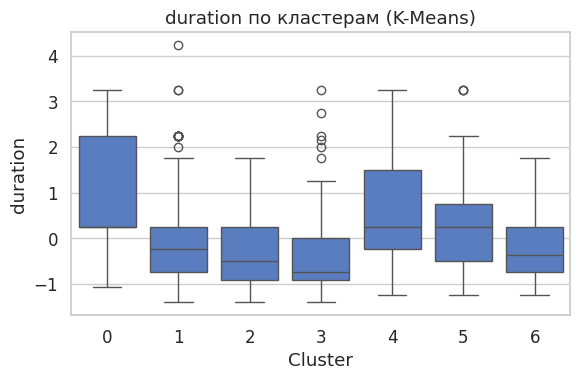

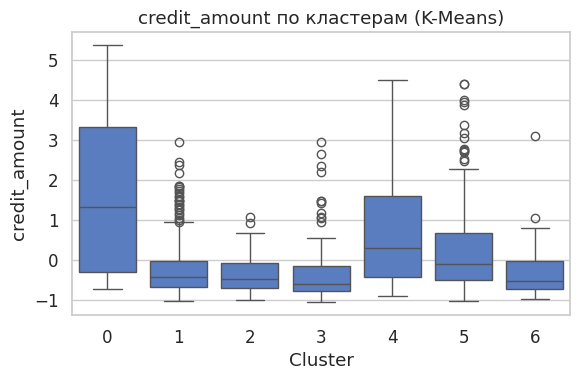

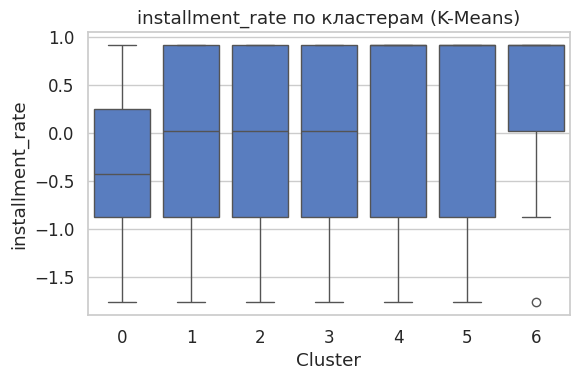

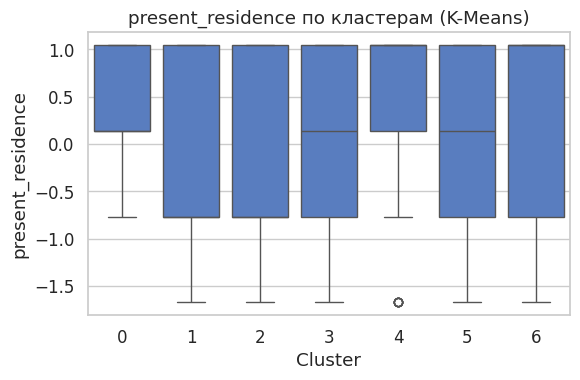

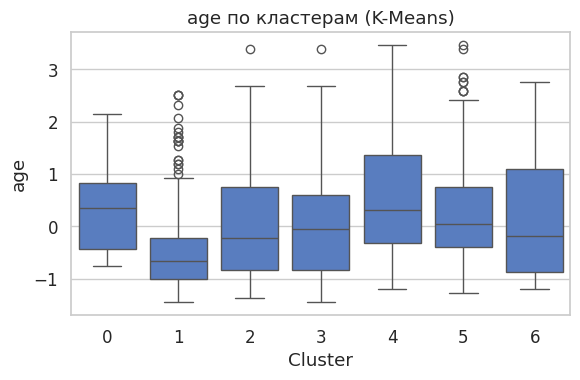

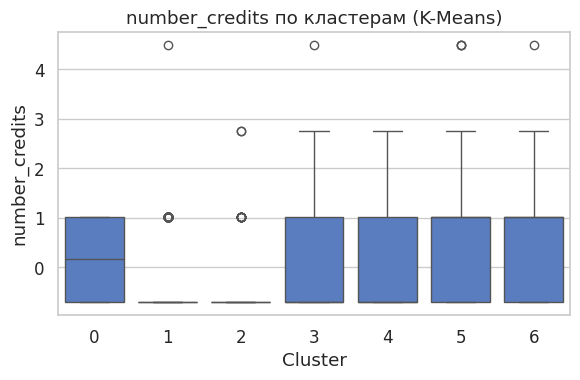

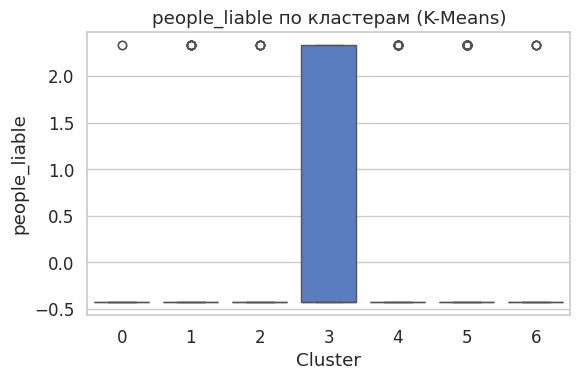

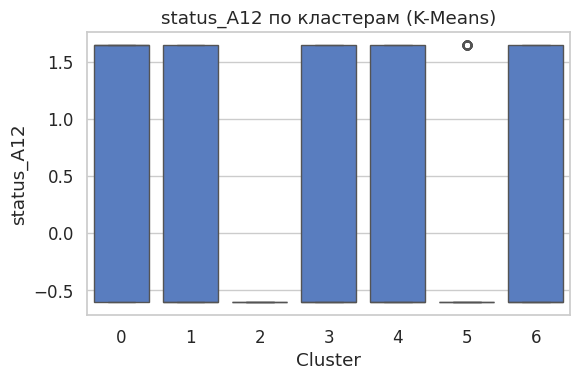

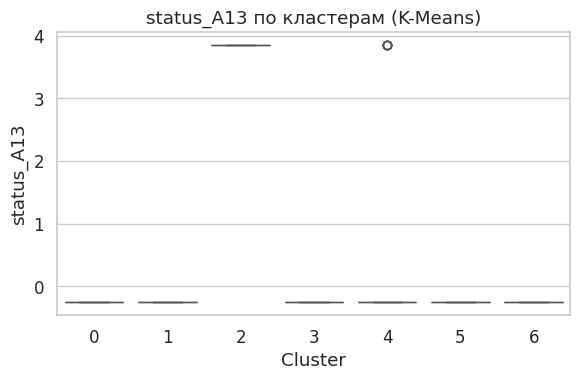

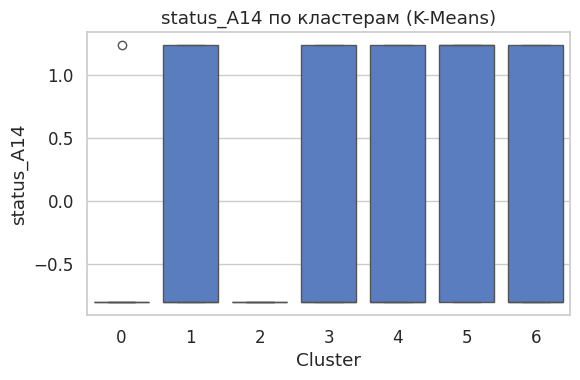

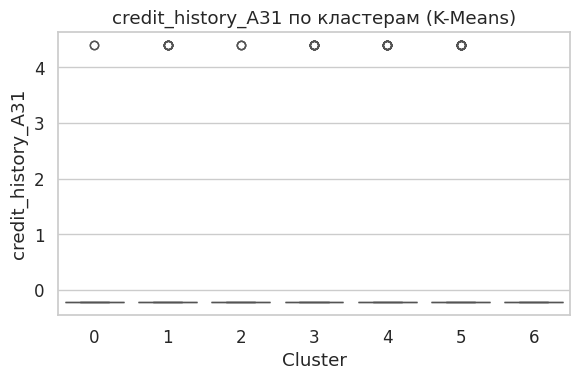

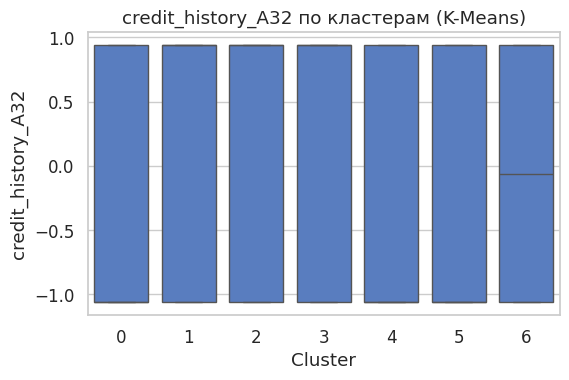

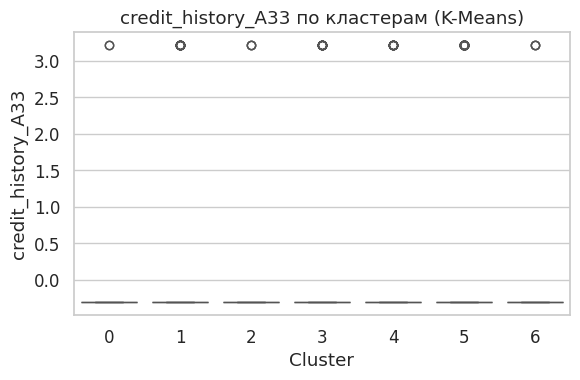

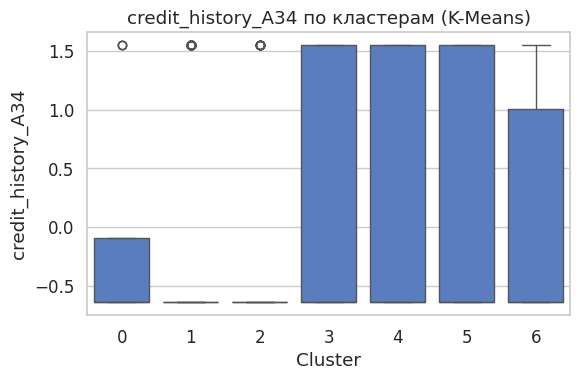

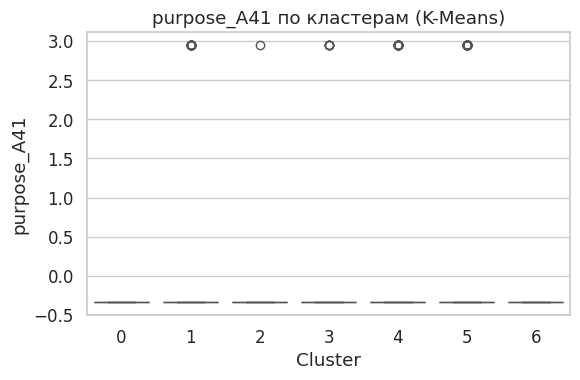

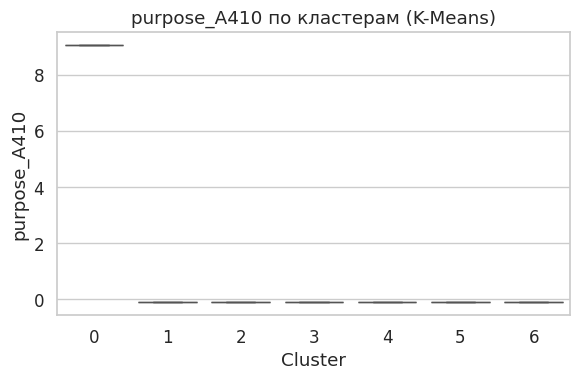

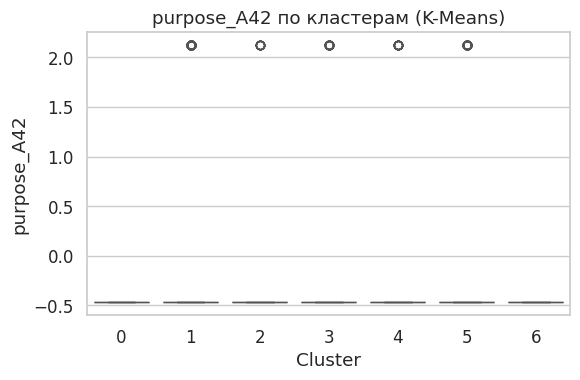

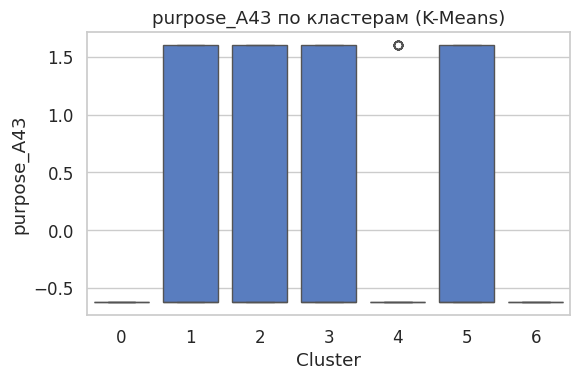

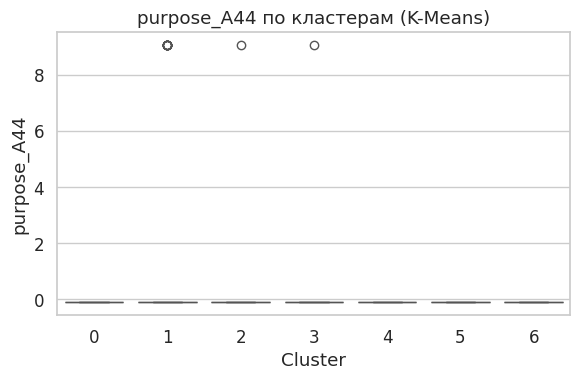

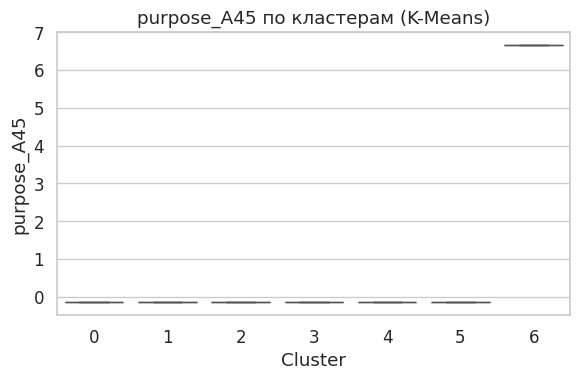

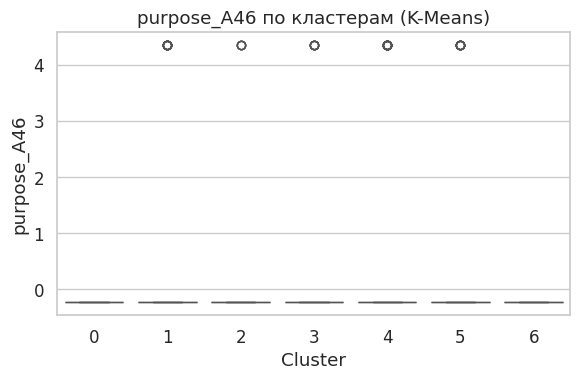

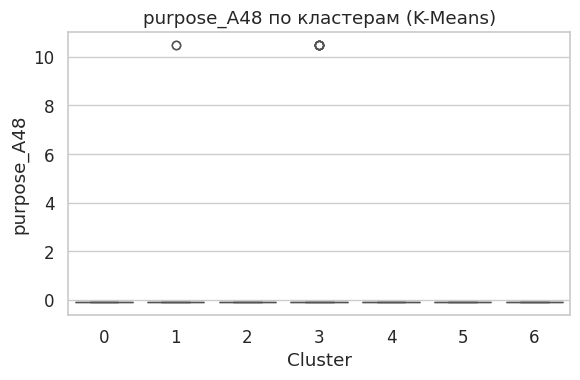

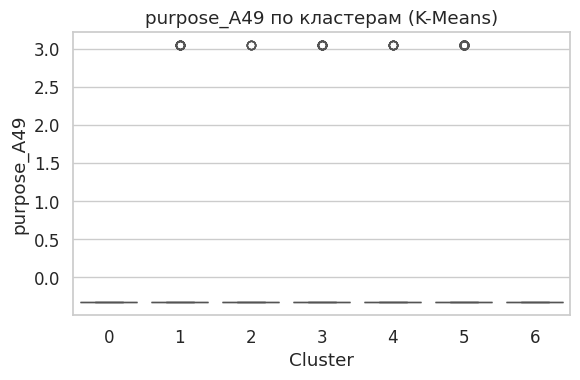

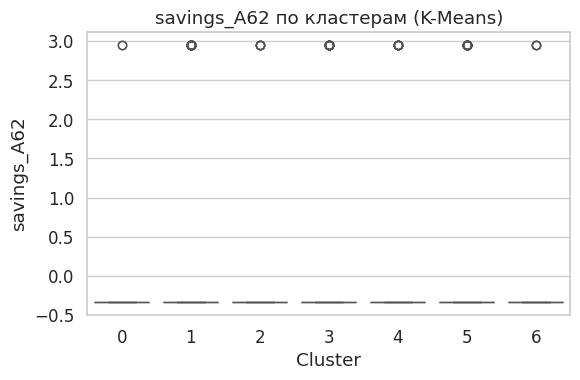

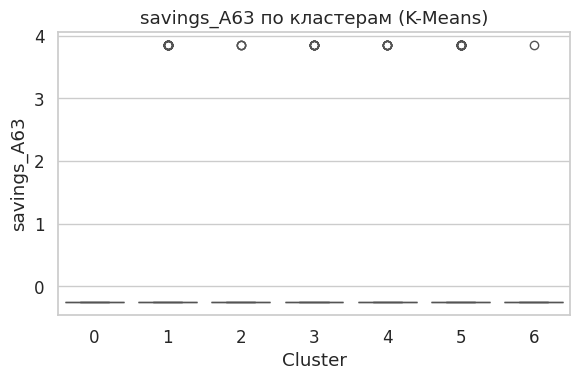

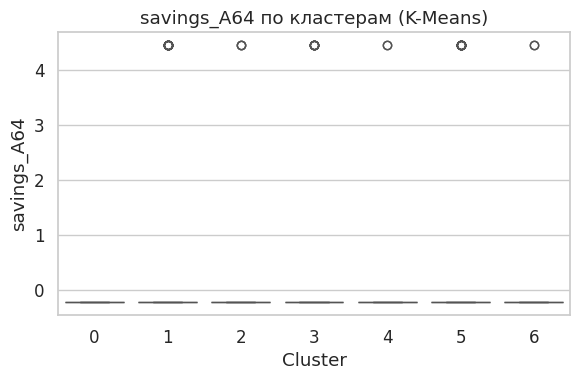

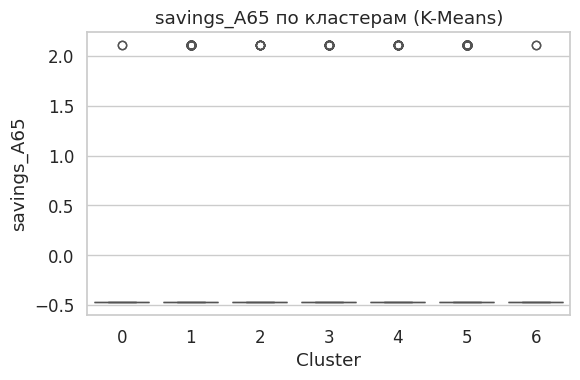

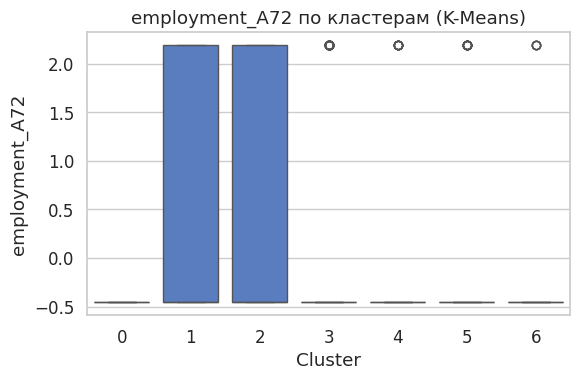

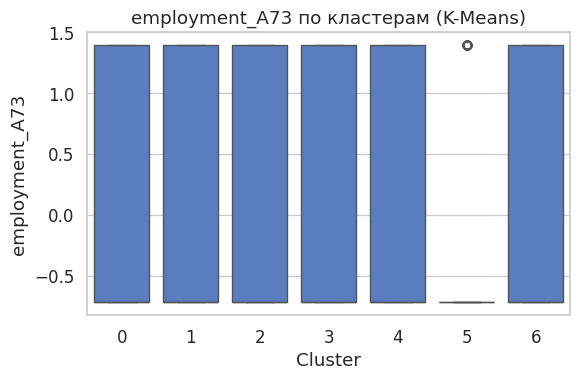

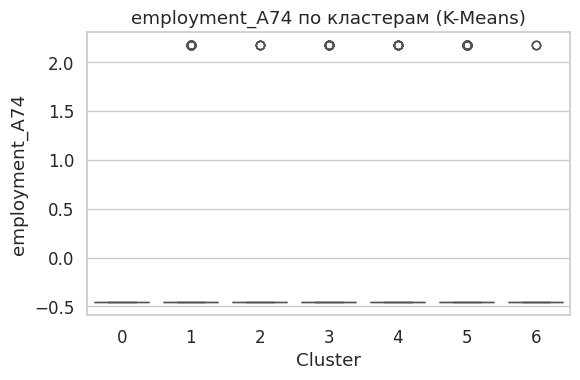

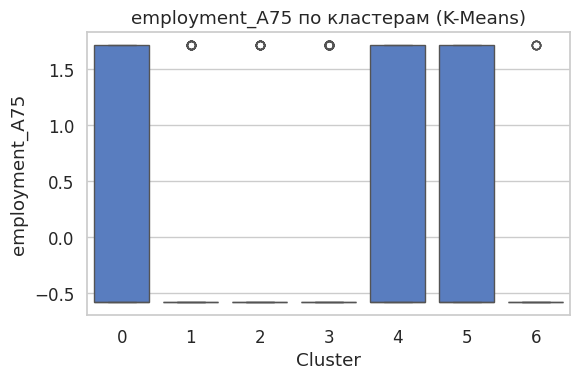

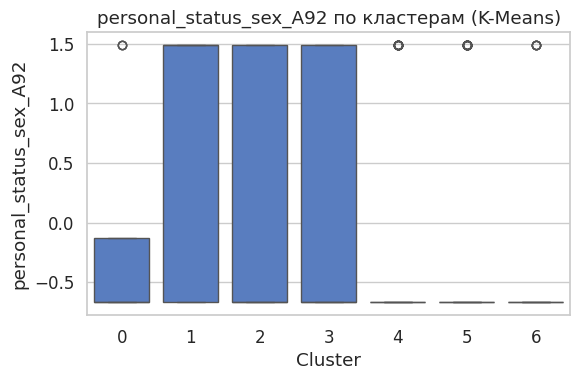

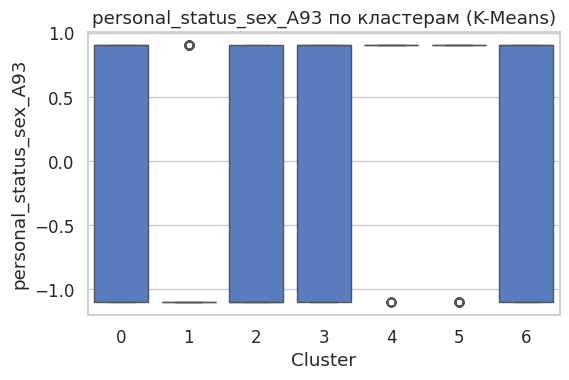

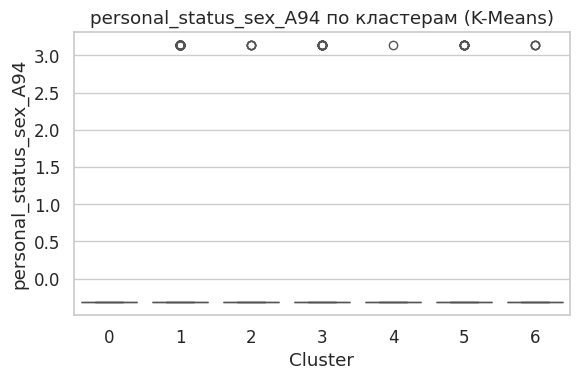

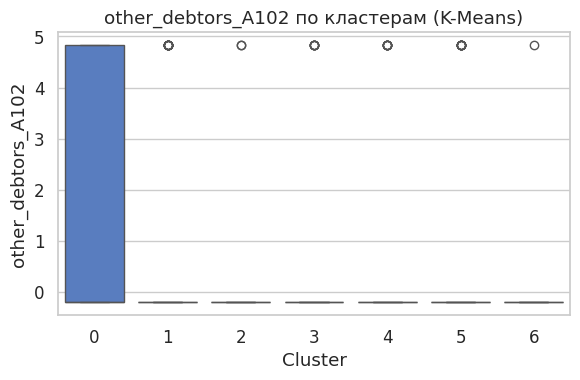

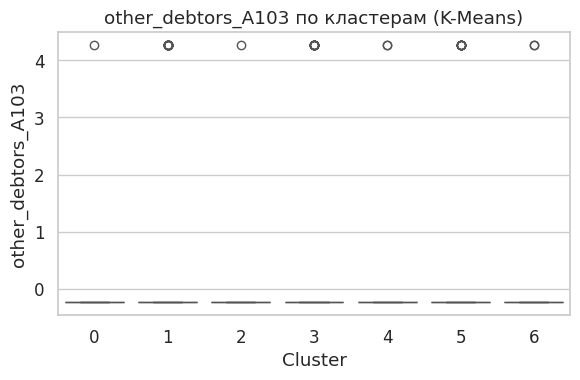

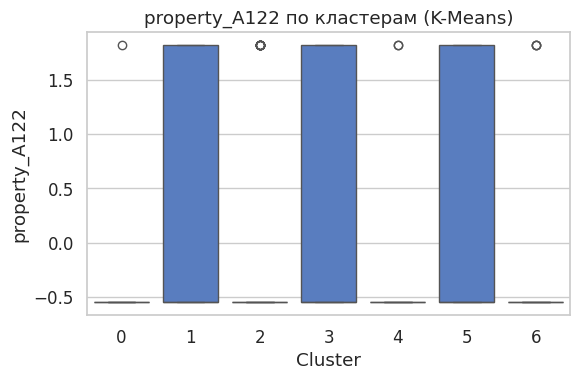

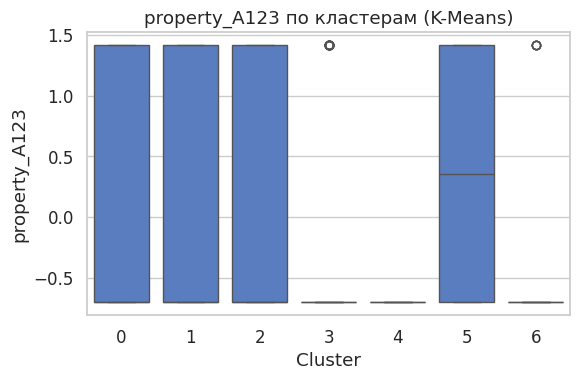

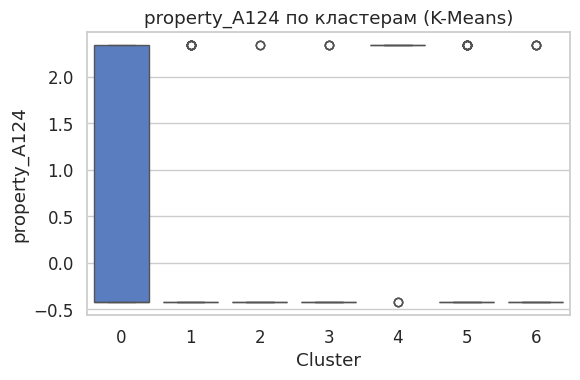

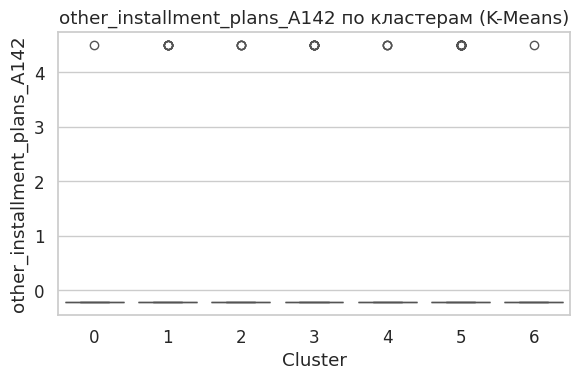

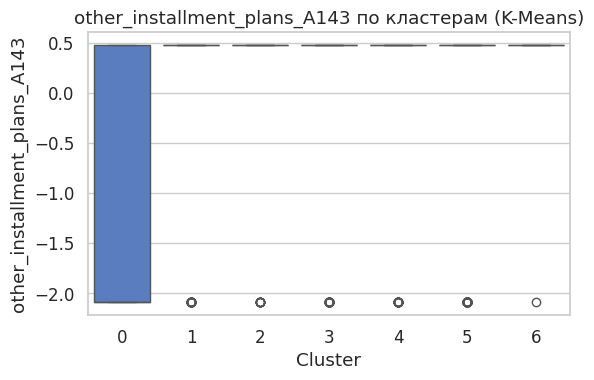

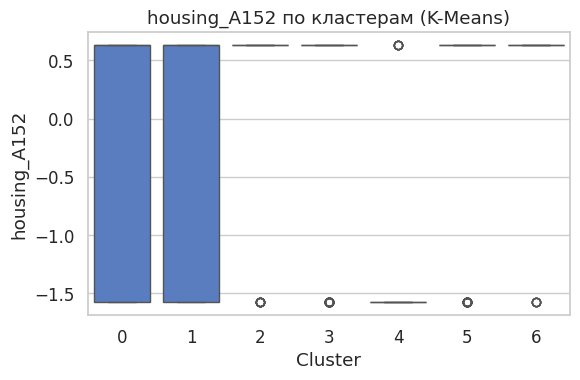

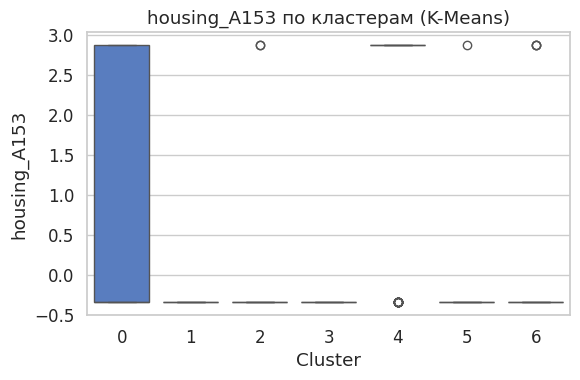

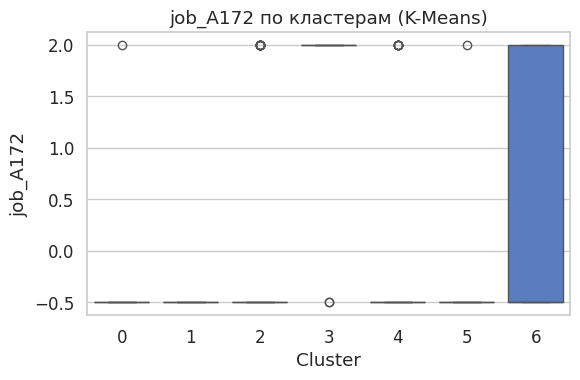

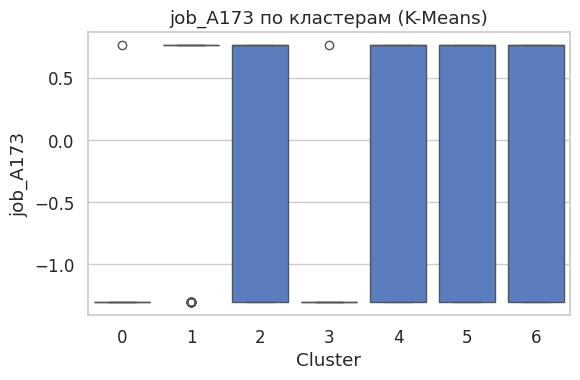

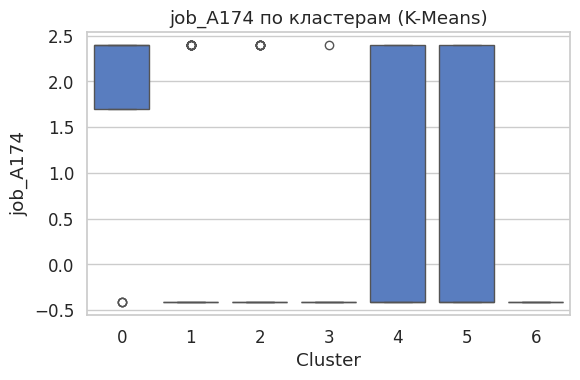

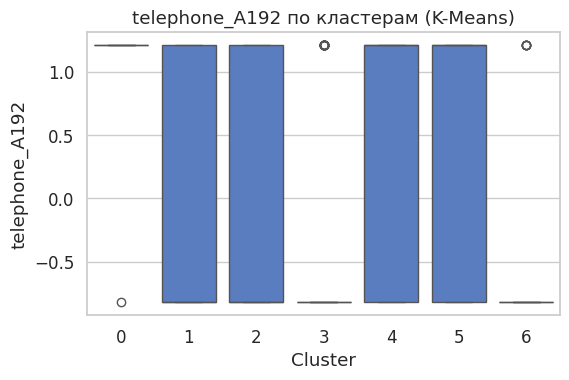

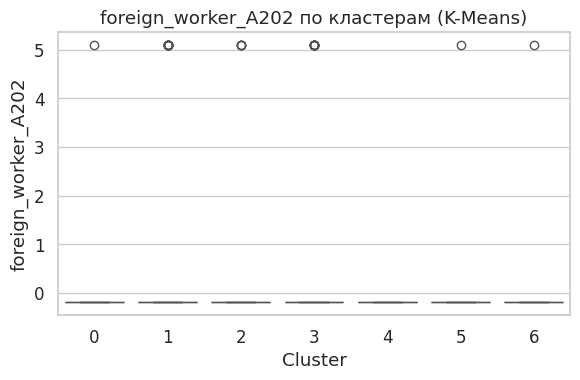

In [83]:
# Boxplot по каждому признаку
for col in X_scaled.columns[:]:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=X_vis, x="Cluster", y=col)
    plt.title(f"{col} по кластерам (K-Means)")
    plt.tight_layout()
    plt.show()


In [84]:
# То же по dbscan
X_vis = X_scaled.copy()
X_vis["Cluster"] = best_labels_db

# Средние (в стандартизированном пространстве)
cluster_means = X_vis.groupby("Cluster").mean(numeric_only=True)
cluster_means


duration  credit_amount  installment_rate  present_residence  \
Cluster                                                                 
-1       0.568085       0.882916          0.024147           0.140505   
 0      -0.000026      -0.006469         -0.002702          -0.004007   
 1      -0.337654      -0.628520          0.173202          -0.161656   
 2       0.957575       1.872000         -0.373333           0.442665   
 3      -0.757105      -0.732056          0.421627           0.140505   

              age  number_credits  people_liable  status_A12  status_A13  \
Cluster                                                                    
-1       1.073372       -0.271925      -0.428290    0.520927   -0.259299   
 0      -0.004956        0.005088       0.003633   -0.008997    0.004866   
 1      -0.113986       -0.560592      -0.428290   -0.230772    0.083689   
 2       0.284243        0.449744       0.185746    0.896777   -0.259299   
 3      -0.077340       -0.127591       0.185746    0.145078   -0.259299   

         status_A14  credit_history_A31  credit_history_A32  \
Cluster                                                       
-1        -0.806328            0.931125           -0.561011   
 0         0.009313           -0.015988           -0.002033   
 1        -0.124155            0.159048            0.607762   
 2        -0.578937            0.287727           -0.394043   
 3         0.103235            0.802445            0.051203   

         credit_history_A33  credit_history_A34  purpose_A41  purpose_A410  \
Cluster                                                                      
-1                 0.571842           -0.643760    -0.338862      6.777777   
 0                -0.000029            0.011286     0.011927     -0.110208   
 1                -0.310630           -0.460666    -0.338862     -0.110208   
 2                 0.473790            0.088618    -0.338862      9.073772   
 3                -0.310630           -0.399634    -0.338862     -0.110208   

         purpose_A42  purpose_A43  purpose_A44  purpose_A45  purpose_A46  \
Cluster                                                                    
-1         -0.470108    -0.623610    -0.110208     1.554369    -0.229416   
 0          0.016546     0.021949    -0.110208    -0.001778     0.008075   
 1         -0.470108    -0.623610     9.073772    -0.149983    -0.229416   
 2         -0.470108    -0.623610    -0.110208    -0.149983    -0.229416   
 3         -0.470108    -0.623610    -0.110208    -0.149983    -0.229416   

         purpose_A48  purpose_A49  savings_A62  savings_A63  savings_A64  \
Cluster                                                                    
-1         -0.095298    -0.327749    -0.338862    -0.259299     0.944958   
 0         -0.095298     0.011536     0.001710    -0.003656     0.003061   
 1         -0.095298    -0.327749    -0.064702     0.426677    -0.224544   
 2         -0.095298    -0.327749     0.392231    -0.259299    -0.224544   
 3         10.493384    -0.327749    -0.338862     0.198018    -0.224544   

         savings_A65  employment_A72  employment_A73  employment_A74  \
Cluster                                                                
-1          0.173276       -0.455773        0.340115       -0.458970   
 0         -0.007437        0.002326       -0.001037        0.002501   
 1          0.173276        0.427508        0.164072       -0.019344   
 2         -0.185920       -0.455773       -0.011971       -0.458970   
 3          0.676150       -0.161346       -0.246695        0.420283   

         employment_A75  personal_status_sex_A92  personal_status_sex_A93  \
Cluster                                                                     
-1             0.568168                 0.410817                -0.598765   
 0             0.006196                -0.003268                 0.007555   
 1            -0.581969                 0.410817                -0.431325   
 2            -0.07

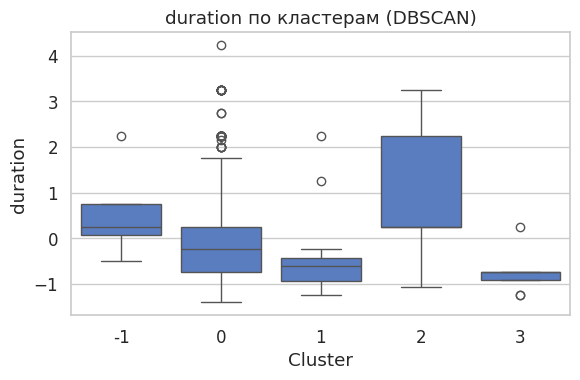

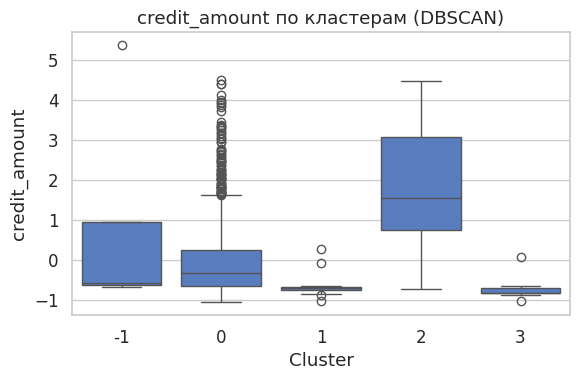

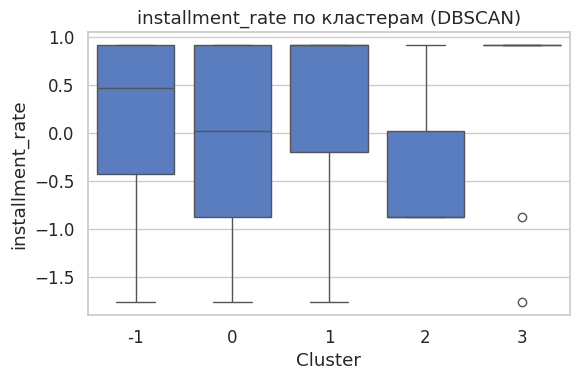

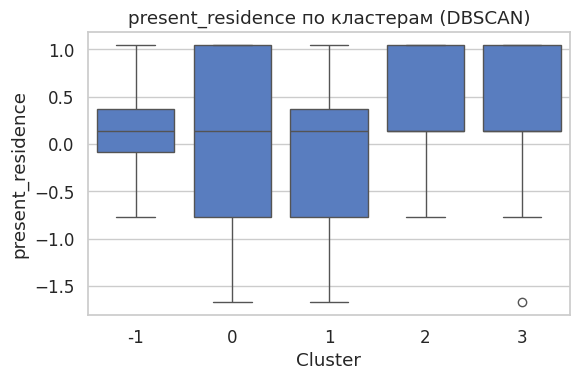

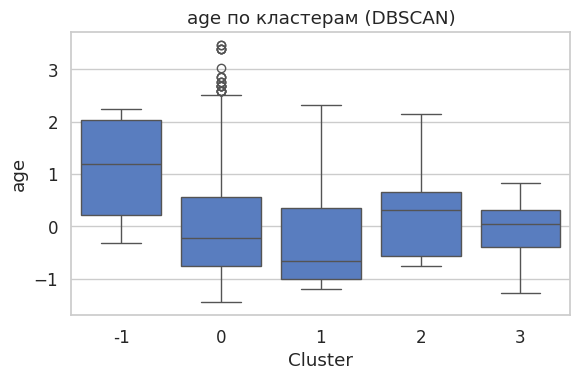

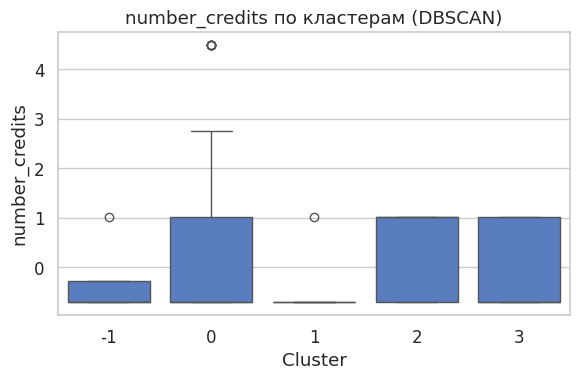

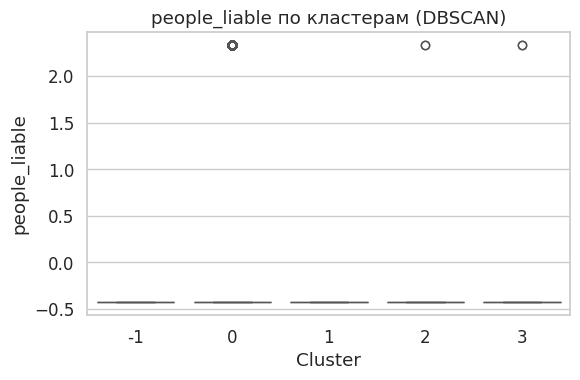

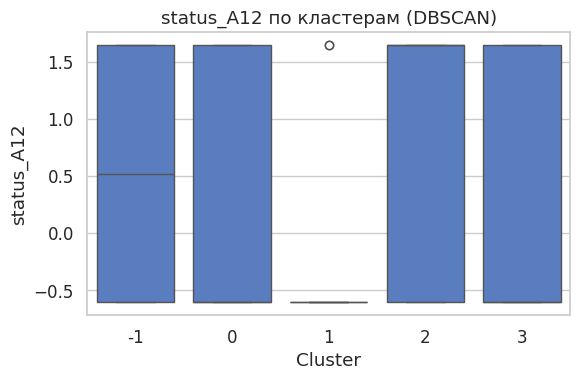

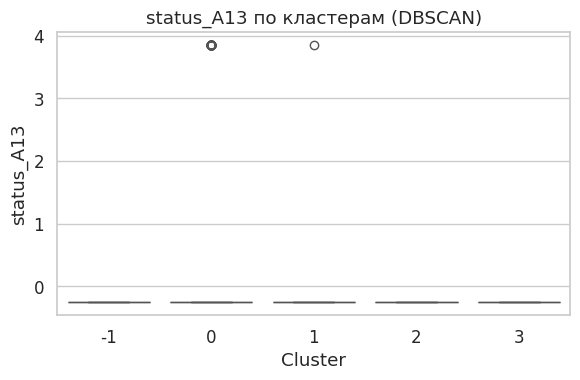

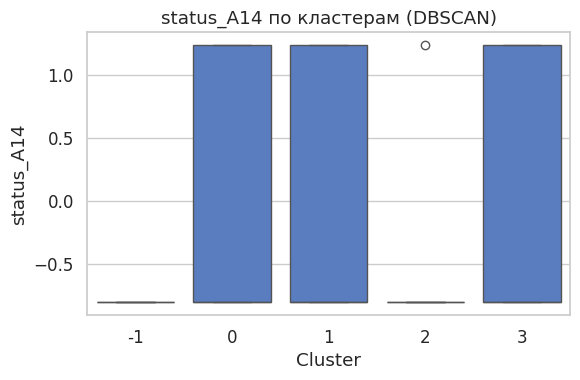

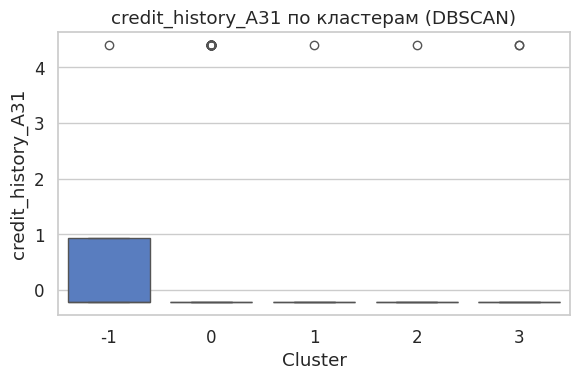

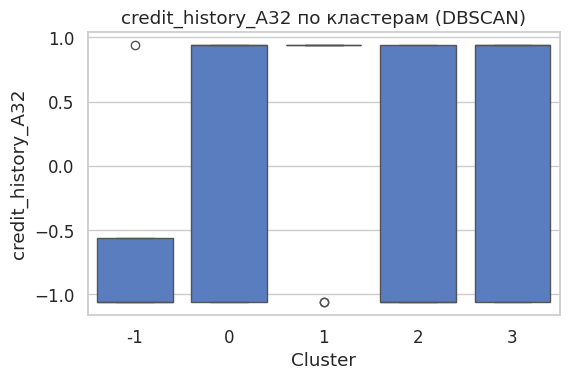

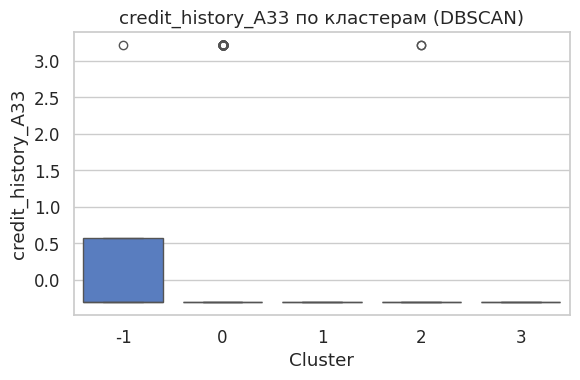

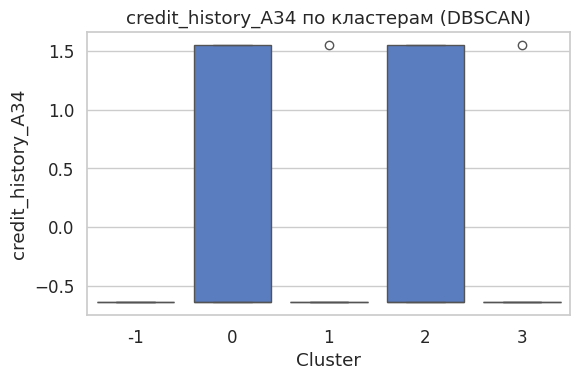

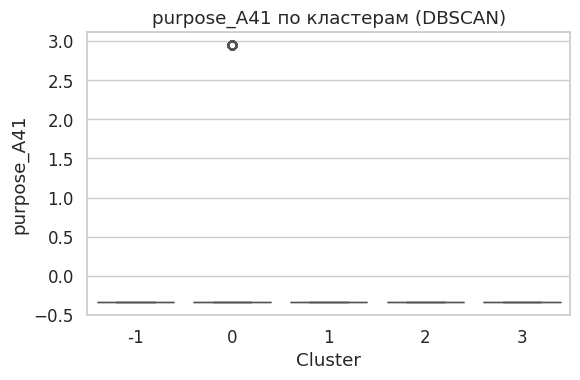

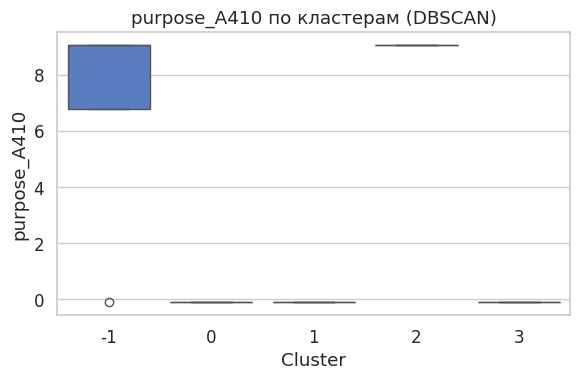

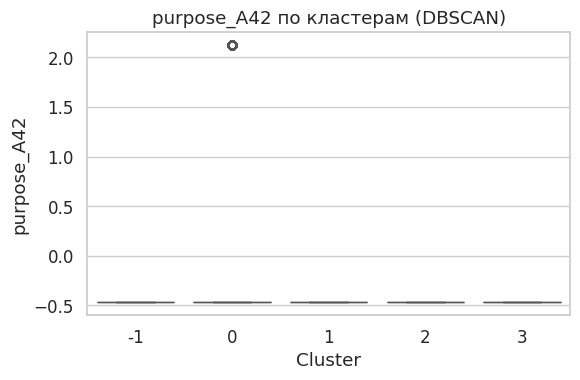

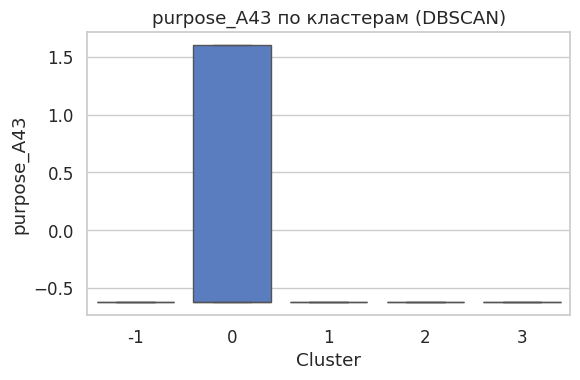

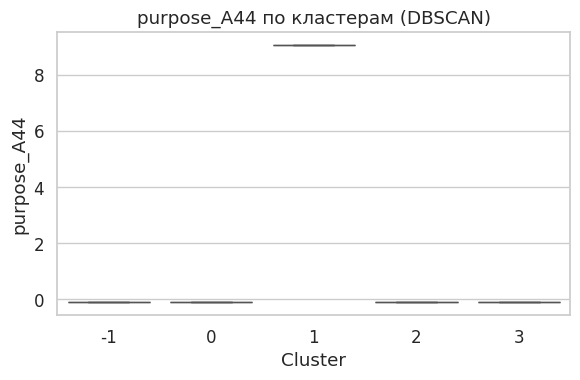

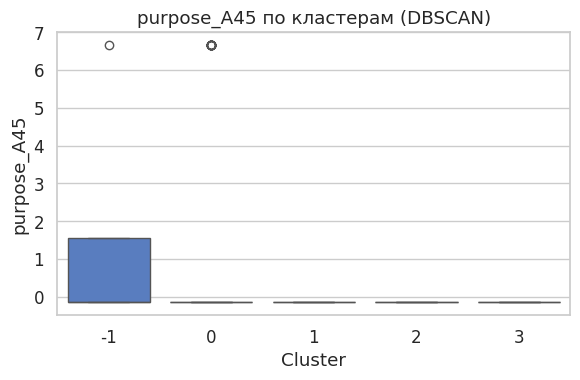

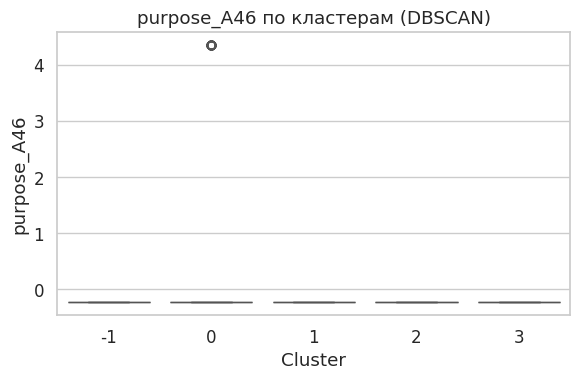

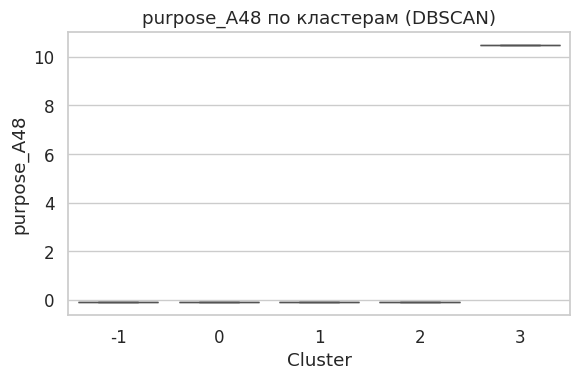

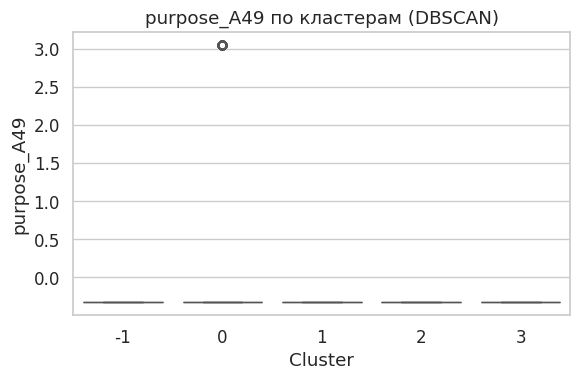

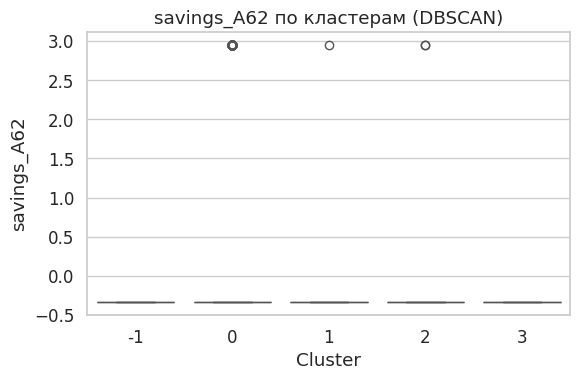

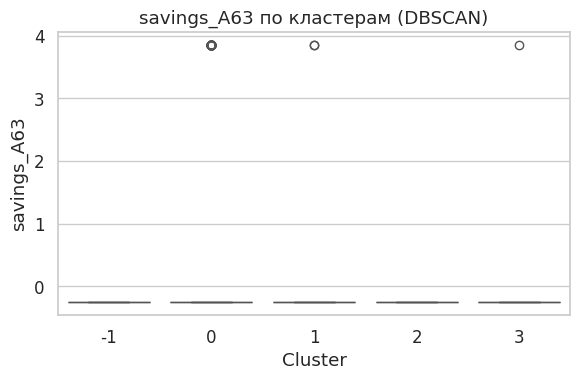

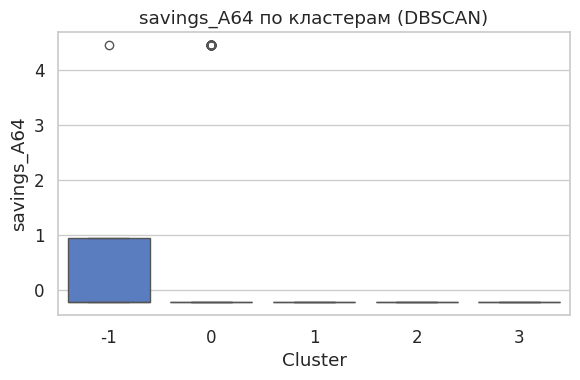

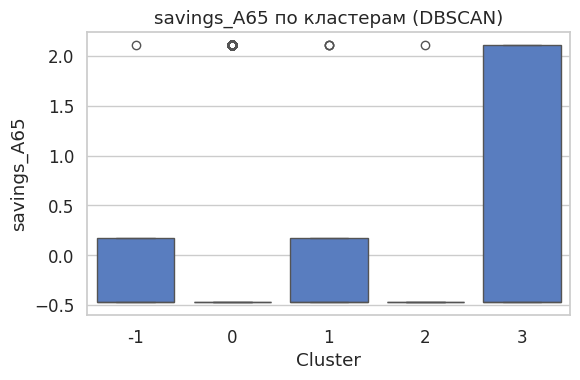

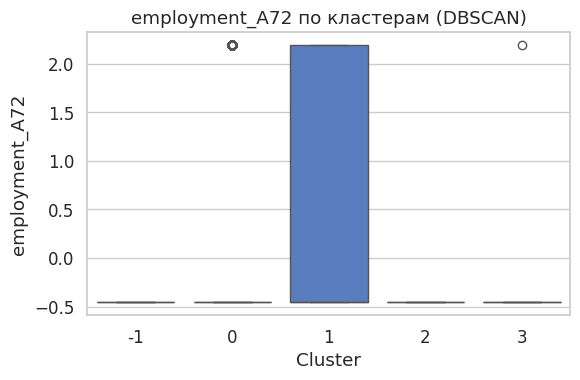

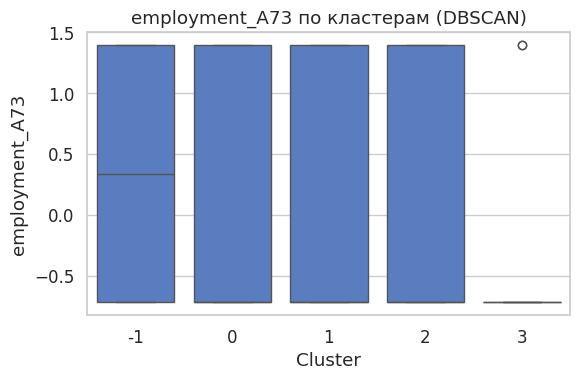

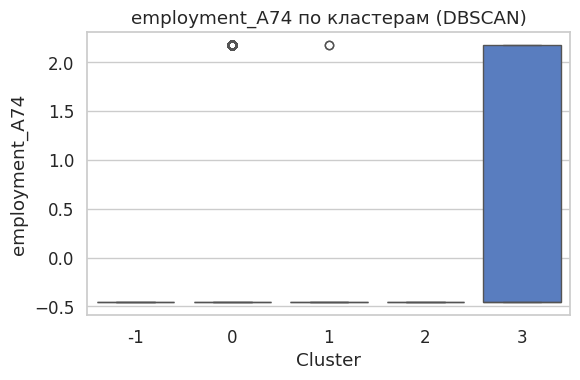

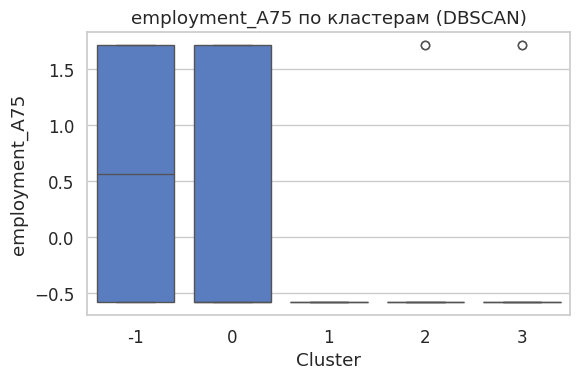

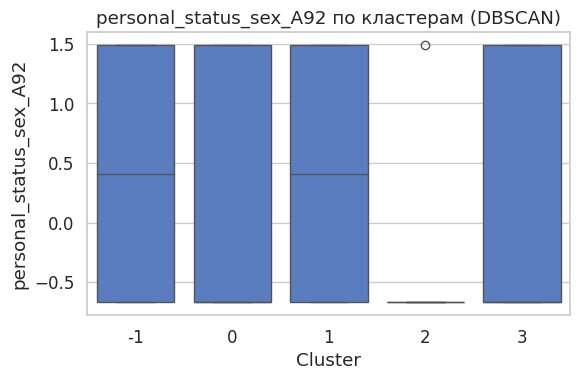

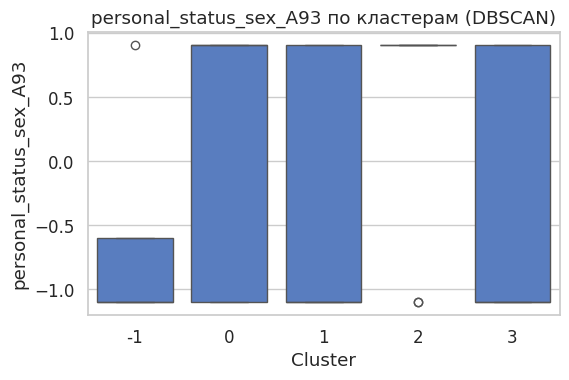

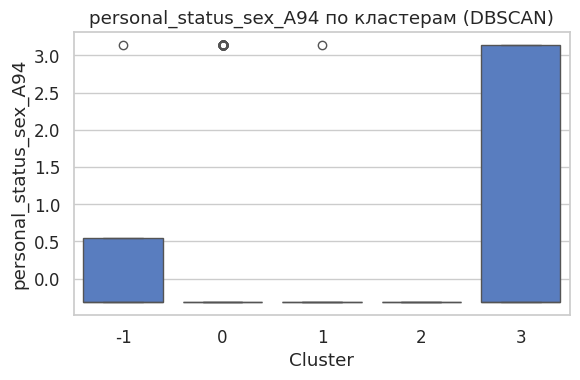

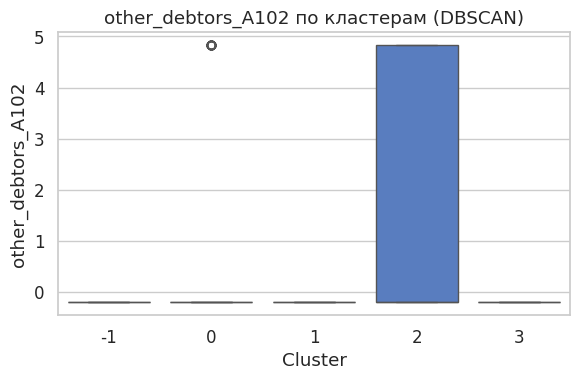

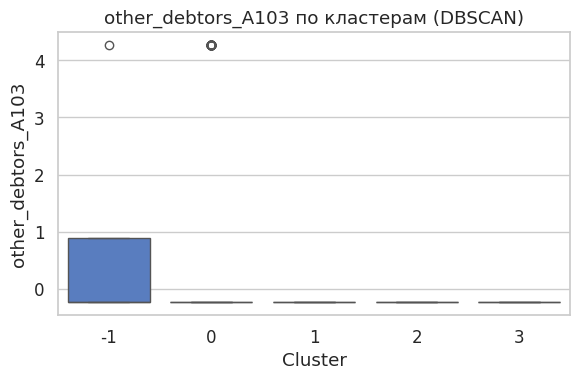

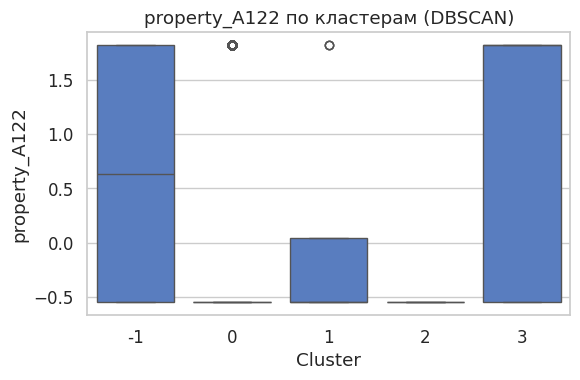

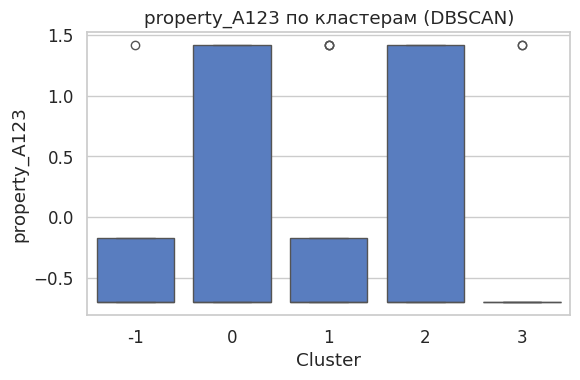

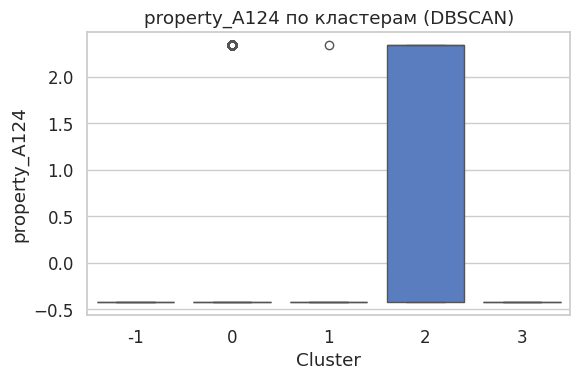

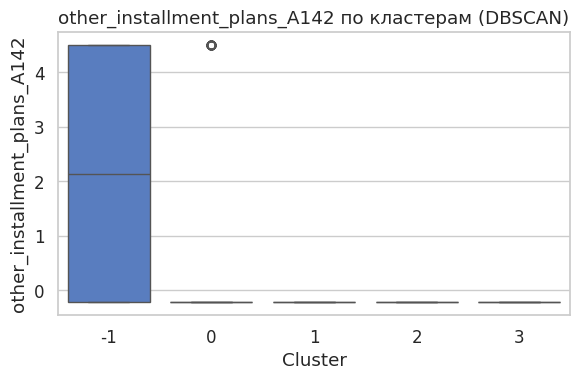

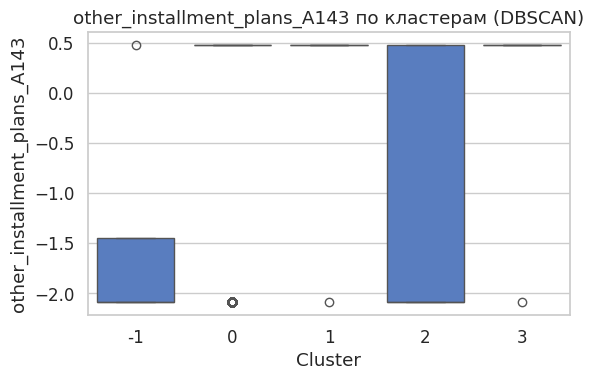

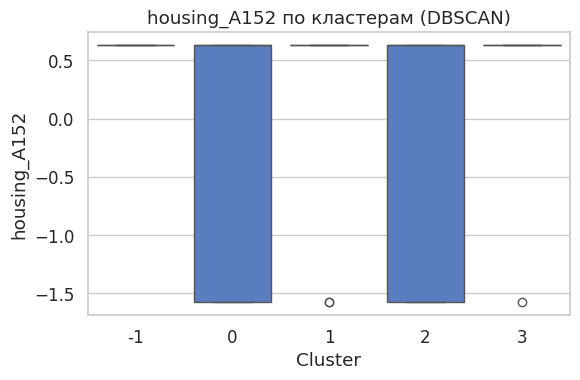

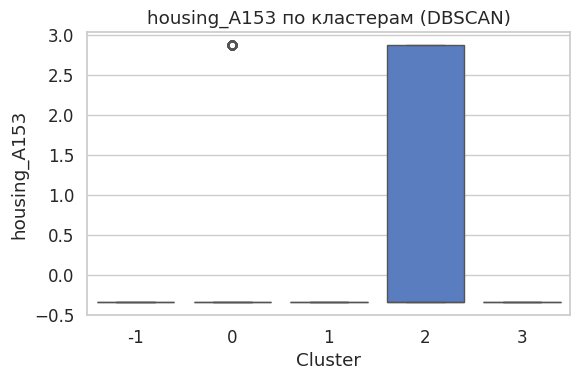

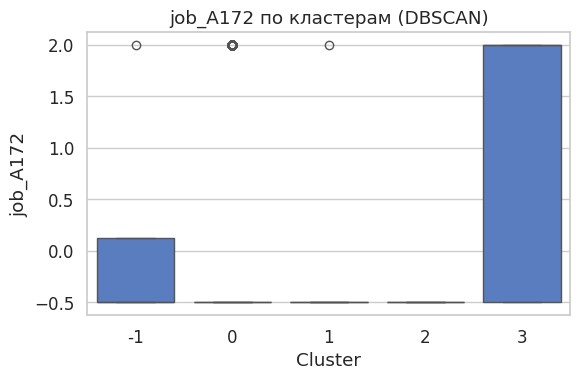

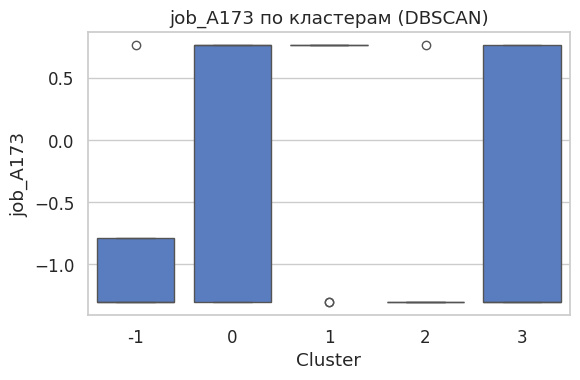

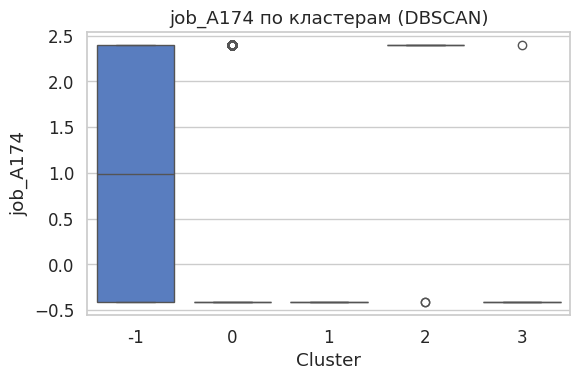

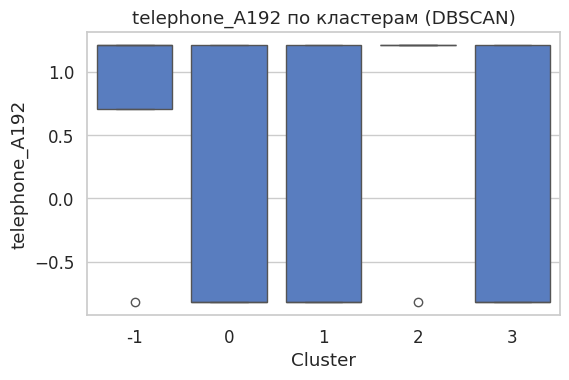

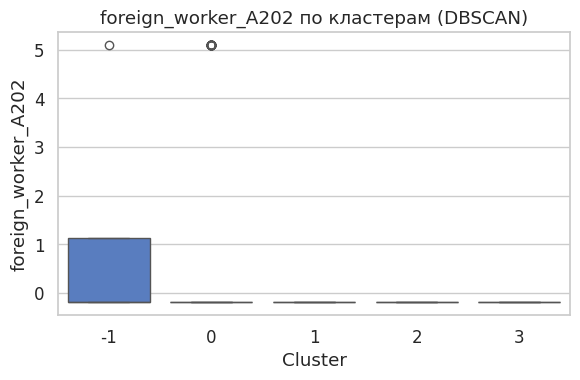

In [85]:
# Boxplot по каждому признаку
for col in X_scaled.columns[:]:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=X_vis, x="Cluster", y=col)
    plt.title(f"{col} по кластерам (DBSCAN)")
    plt.tight_layout()
    plt.show()


In [87]:
 # До кучи сделаем k-means на 2 кластерах
kmeans = KMeans(n_clusters=2, n_init="auto", random_state=42)
labels_km = kmeans.fit_predict(X_scaled)

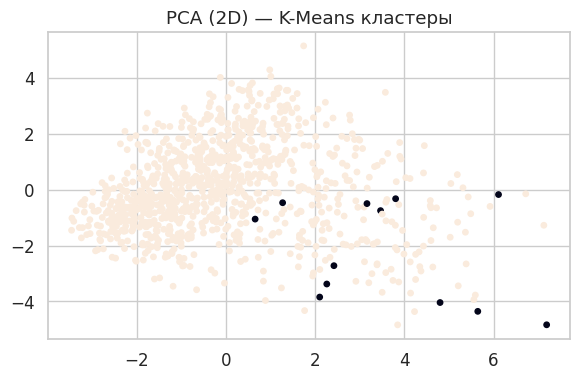

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


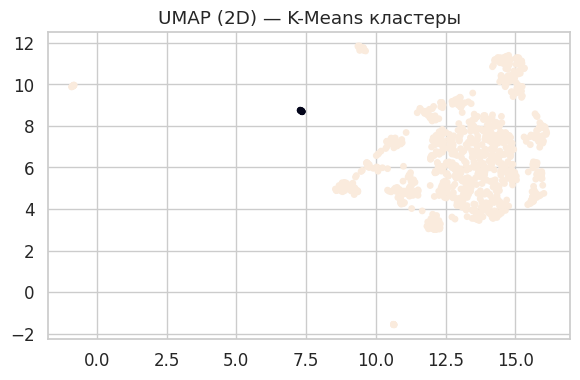

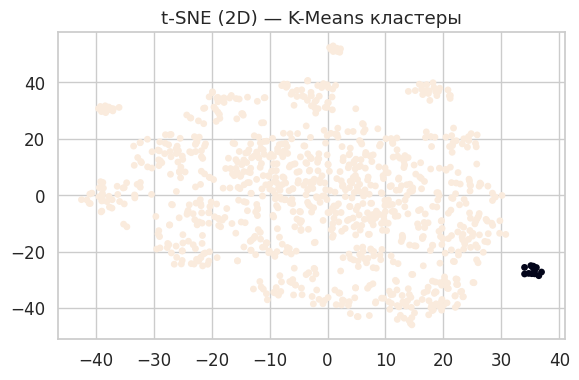

In [88]:
# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_km, s=15)
plt.title("PCA (2D) — K-Means кластеры")
plt.tight_layout()
plt.show()

# UMAP
um = umap.UMAP(random_state=42)
X_umap = um.fit_transform(X_scaled)

plt.figure(figsize=(6,4))
plt.scatter(X_umap[:,0], X_umap[:,1], c=labels_km, s=15)
plt.title("UMAP (2D) — K-Means кластеры")
plt.tight_layout()
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto")
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(6,4))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels_km, s=15)
plt.title("t-SNE (2D) — K-Means кластеры")
plt.tight_layout()
plt.show()


## **Выводы**

1. **Сравнение локтя и силуэта**  
   - В исходных данных метод локтя указывал на **7 кластеров**, однако метрика силуэта была максимальной при **2 кластерах**, что сигнализирует о слабой кластерной структуре.  
   - Видимо группы плохо разделяются (и даже после PCA не очень)

2. **Влияние PCA**  
   - Снижение размерности до **15 компонент PCA** дало те же 2 кластера, то есть, видимо, 7 это перебор и там есть 2 явных группы

3. **Визуализация t-SNE**  
   - До PCA точки в t-SNE выглядели как плотная «куча», что указывало на отсутствие ярко выраженных групп в высокомерном пространстве.  
   - После PCA визуализация показала чуть более разреженные и отделённые скопления, хотя полного разделения всё равно нет — значит, данные имеют лишь умеренную кластерную структуру.

4. **Практическая интерпретация**  
   - При 2 кластерах сегментация отражает грубое разделение клиентов (возможно, по профилю риска или уровню кредитной нагрузки).  
   - При большем числе кластеров (5–7) группы становятся менее интерпретируемыми и могут отражать скорее статистические различия в отдельных признаках, чем реальные сегменты клиентов.

**Общий вывод**: Для этих данных оптимальным выглядит использование **PCA + 2–3 кластера**, так как это даёт наиболее устойчивую и интерпретируемую сегментацию. Увеличение числа кластеров выше 3 не приводит к значимому улучшению структуры и усложняет интерпретацию.
